Reading with reviews-comp/reviews_553850.csv


,review,positive,neutral,negative
1,Must kill bugs Bugs must die. WHY SO MANY BUGS! YOU KILLED MY WIFE AND KIDS YOU BASTARDS!!,0.002741,0.017329,0.979930
4,Multiplayer doesn't work for me. Tried various fixes to no avail. Not a good single player game.,0.004285,0.035294,0.960421
5,It's good.,0.944524,0.050550,0.004926
6,Fast paced and fun co-op. Patches have balanced and fixed bugs. Crazy fun with friends.,0.973771,0.023938,0.002291
9,Really fun. Worth every penny.,0.970555,0.025752,0.003693
13,Cannot recommend this game enough.,0.815711,0.126310,0.057978
14,I bought this game and literally built a pc so I could play it. While I've only been playing for a little over 2 weeks I'm level 100 because I've been playing for 2 weeks straight. It's such a good game and the more I learn about it the better it gets. It literally is the perfect game and is everything I've ever wanted in a video game. Except tanks. Psst Arrowhead.,0.989883,0.007818,0.002299
16,A great sequel that one can pick up and play with friends and immediately put down to repeat the next day.,0.862173,0.126119,0.011708
18,good game,0.926890,0.064623,0.008486
21,very fun and action packed highly recommended,0.982841,0.015412,0.001747


,review,positive,neutral,negative
23,im just gonna leave this here https://medal.tv/games/helldivers-2/clips/iZeVTgQzVSPGpC00v,0.049830,0.804909,0.145261
105,For democracy.,0.152244,0.712373,0.135383
122,I skibidi on that ohio democracy gyatt,0.071308,0.840656,0.088036
130,freedom,0.195887,0.665337,0.138776
146,democracy,0.180660,0.640105,0.179235
150,bring back the trident,0.143324,0.817604,0.039072
153,toes,0.196553,0.611063,0.192384
159,Bet,0.178949,0.638092,0.182959
254,John helldiver real,0.093647,0.761023,0.145330
256,democracy fills my sample container,0.126218,0.760739,0.113043


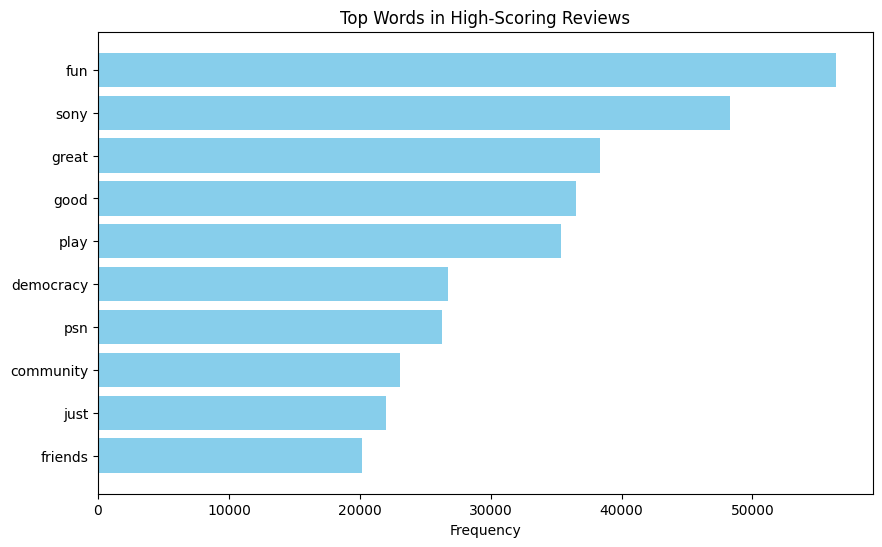

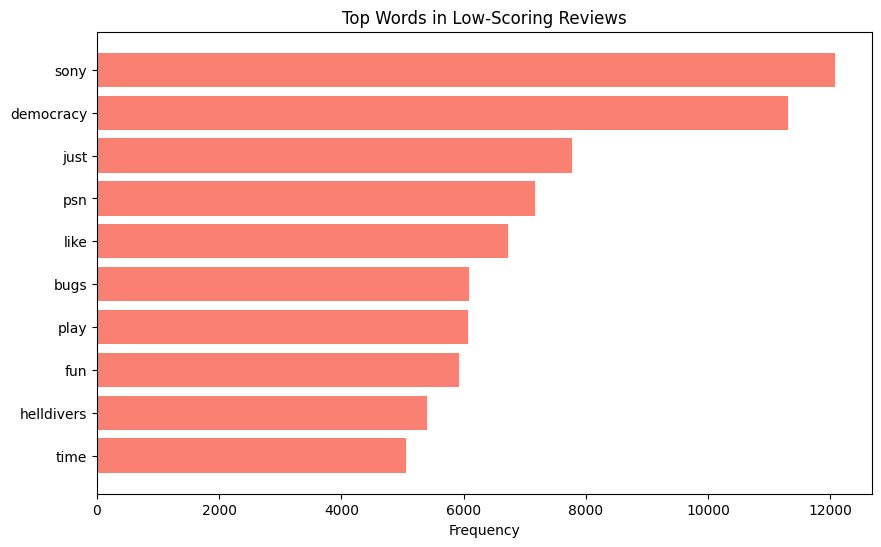

Reading with reviews-comp/reviews_271590.csv


,review,positive,neutral,negative
0,THIS IS MY DREAM TO PLAY GTA ONLINE AND GRAND RP,0.927799,0.069887,0.002314
4,broken on steam deck doesn't work hasn't worked for months,0.007044,0.093585,0.899371
11,Bro this gameMy childhood become True best game I have ever played 👍👍,0.978924,0.018945,0.002132
15,Great game! Lots to do,0.974626,0.022321,0.003054
16,pretty good ass game I fw the cars,0.955585,0.037222,0.007193
22,The best game ever since forever ♾️,0.986882,0.011460,0.001658
26,love the game awesome interactions,0.988108,0.009172,0.002719
31,For 15 dollars its worth it a cool story cool characters and so on.I recomend it to ppl that like story games and open world games.I like the game very much.,0.980780,0.017606,0.001614
34,I love this and anything by Rockstar since it's inception. This runs well even if you don't have a great computer which is nice.,0.983751,0.012830,0.003419
36,great game fun wiht nfrineds,0.959405,0.036219,0.004376


,review,positive,neutral,negative
1,umm please mod single player thats all,0.110342,0.784697,0.104961
2,Bruh game,0.167363,0.750002,0.082635
13,I sometimes just drive or fly around to de-stress,0.079363,0.821245,0.099392
28,grand rgeft a urtp,0.089281,0.776480,0.134240
52,хуета не кому не советую если вы ее покупаете для гта5рп просто умрите от рака плиз а если вы для гта онлайна покупаете то вы красава,0.042131,0.841242,0.116627
77,its gta5 baby,0.176286,0.790354,0.033359
87,Steam Annual Promotions 2024 Steam Spring Sale: March 14-21 Deck Building Game Festival: March 25th April 1st FPS Game Festival: April 15-22 Farm Management Game Festival: April 29th to May 6th Infinite replay game festival: May 13-20 Open World Survival Game Festival: May 27th to June 3rd Next Fest New Product Festival: June 10-17 Steam Summer Sale: June 27th - July 11th Tower Defense Game Festival: July 29th to August 5th Fighting Game Festival: August 5-12 Rhythm Game Festival: August 19-26 Space Exploration Game Festival: September 2-9 Airplane Train and Car Game Festival: September 16-23 Turn based Role Playing Game Festival: September 30th to October 7th Next Fest New Product Festival: October 14-21 Steam Scream Game Festival: October 28th to November 4th Cooking Game Festival: November 11-18 Steam Autumn Sale: November 27th December 4th Steam Winter Sale: December 19th - January 2nd 2025: ·Real time Strategy Game Festival: January 20-27 (PT) ·AFK Game Festival: February 3-10 (PT) ·Sofa Cooperation Game Festival: February 10-17 (PT) ·Steam New Product Festival February Edition: February 24th to March 3rd (PT) ·Visual Novel Game Festival: March 3-10 (PT) ·Steam Spring Sale: March 13-20 (PT) ·Urban Construction and Colonial Simulation Game Festival: March 24-31 (PT) ·Box pushing Game Festival: April 21-28 (PT) ·War Game Festival: April 28th May 5th (PT) ·Biological Collection Game Festival: May 12-19 (PT) ·Zombie vs. Vampire Game Festival: May 26th June 2nd (PT) ·Steam New Product Festival June Edition: June 9-16 (PT) ·Fishing Game Festival: June 16-23 (PT) ·Steam Summer Sale: June 26th - July 10th (PT),0.071407,0.871385,0.057208
115,Drove car in a building walked home Started loading Gta,0.052817,0.889773,0.057409
127,cvbmjdakvakljwrjge,0.070261,0.746055,0.183684
130,khelooo bhenchoo,0.186151,0.724313,0.089536


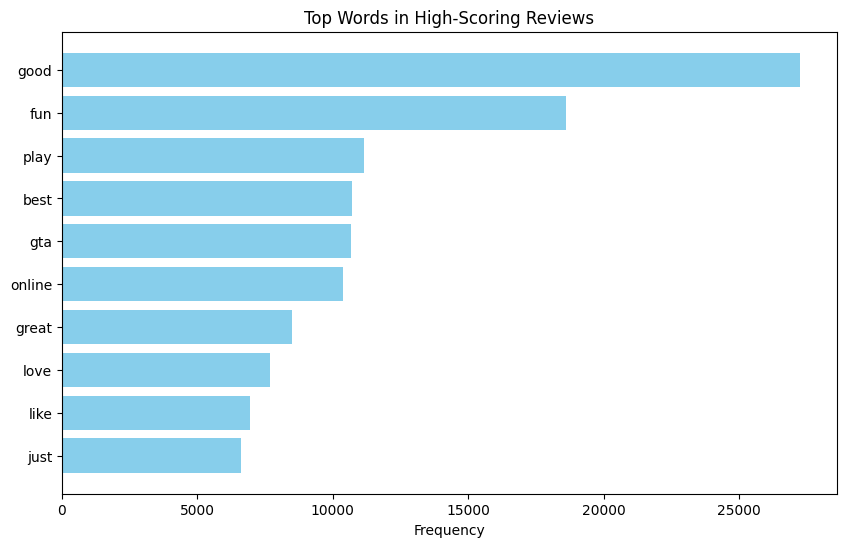

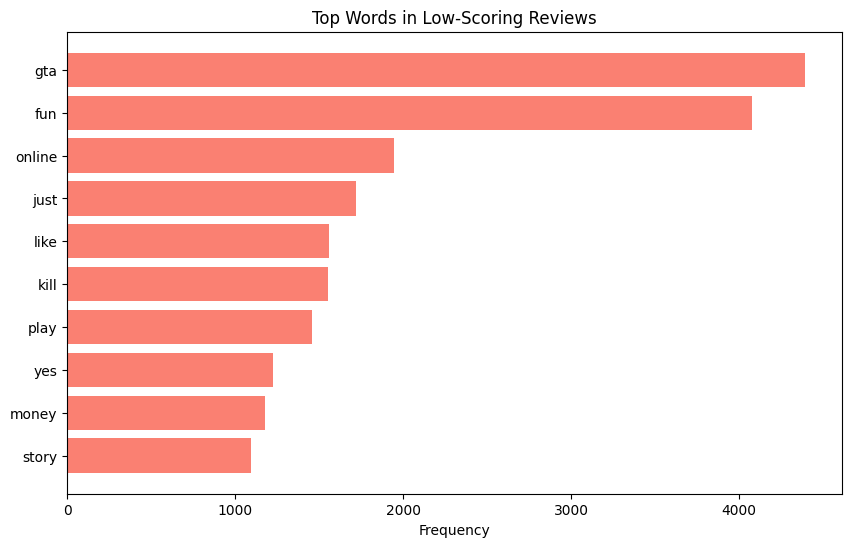

Reading with reviews-comp/reviews_2420110.csv


,review,positive,neutral,negative
1,Beautiful cinematics in depth story great combat. The best is the comments NPCs say when you are just standing around near them!,0.959914,0.035109,0.004978
2,Nothing short of amazing a lot of QoL improvement over Zero Dawn. Wonderful image story and the model's facial mapping is just superb..,0.978489,0.018269,0.003242
4,Great game! The story line characters challenges all come together in this intuitive vast 3-D world. Highly recommend this game coming from a PC user. It's awesome!,0.991293,0.007263,0.001444
6,one of the most fun games i have ever played.,0.988864,0.009049,0.002087
8,A masterpiece!,0.907588,0.086093,0.006319
11,TOO MANY GLITCHES GAME PLAY SUCKS ITS LIKE THE CODE WRITERS ARE 5 YEARS OLD GRAPHICS SUCK IT FEELS OUTDATED IN 2024 MORE LIKE 1999 GAMES DONT WATE YOUR TIME MONEY THESE BASTARS SHOULD NO BE ALLOWED TO REPRODUCE,0.002950,0.018604,0.978445
12,Visually appealing lots to explore plus an exciting and captivating story. Combat could be improved but overall a good game!,0.973047,0.024199,0.002754
14,The character expression is a big improvement over Zero Dawn. The gameplay is more complicated then Zero Dawn but it's fun once you get a hand of it.,0.929364,0.063234,0.007401
15,its a good contienuation of the first game please excuse the spelling,0.812595,0.165928,0.021477
17,Played this straight after forbidden west. Amazing sequel after 90 Hours Ive exhausted pretty much everything apart from new game plus. 10/10 would recommend.,0.948719,0.042352,0.008929


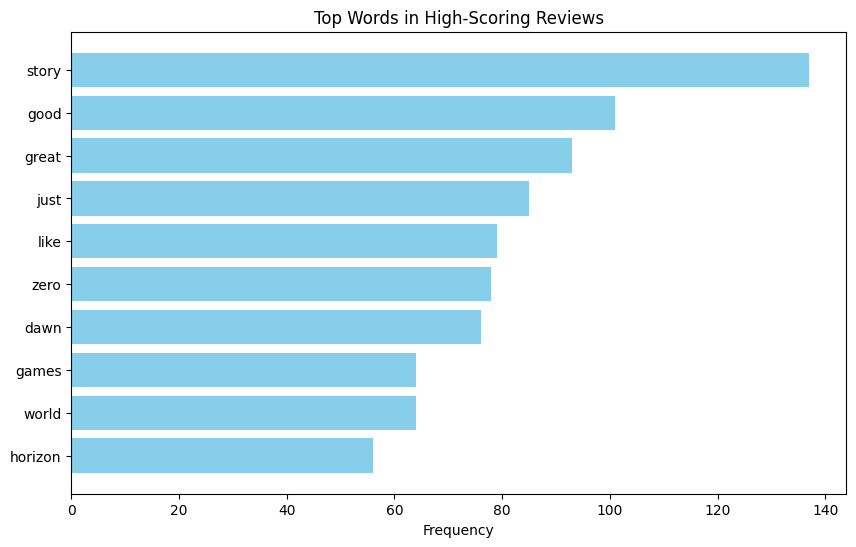

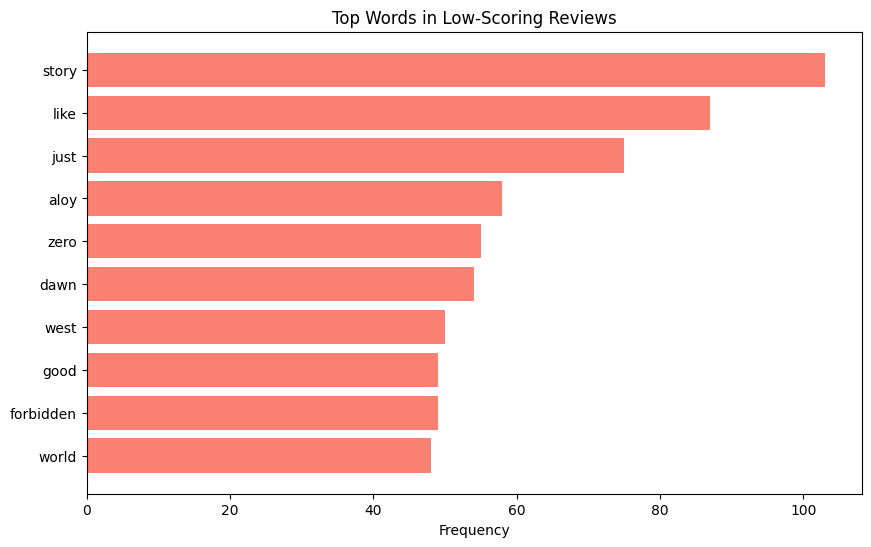

Reading with reviews-comp/reviews_1546990.csv


,review,positive,neutral,negative
3,It's fun better than III but still quite lacking. Kind of biased since I'm from Miami which this game Vice City is a depiction of but nonetheless I think this map is superior to Liberty City and overall this game is. The whole vibe of the city especially at night is unmatched. The characters are memorable the story is simple yet great and the gameplay is a little over par than that of III's. Either way I can't wait to see whats in store for VI when it shows it's modern rendition of Miami.,0.916893,0.068894,0.014213
7,Games are goodjust buy them on sale days,0.910741,0.078720,0.010540
8,Super!!!!,0.878582,0.107161,0.014257
10,I got a great dose of nostalgia even for a definitive remaster version mainly because of the soundtrack and the whole 80s Miami atmosphere. Its not a great remaster but its alright and the story is much cooler and understandable playing it as an adult.,0.968843,0.028085,0.003073
13,The radio and the whole atmosphere of the game is really good. I think VC is the best in the definitive trilogy closely followed by SA.,0.985118,0.013467,0.001415
15,My favourite GTA.,0.913020,0.080674,0.006306
17,"Devs have fucked the game when i first got this i was able to play it just fine and really appreciated it for its nostalgic elements during recent updates im facing inexcusable issues such as buildings 30 feet up the road not rendering properly and looking like complete shit (almost paper mache) my guess is they are trying to fix performance for lower end rigs but its not working i used to be able to play this game capped @60fps on the highest possible settings in 1440p un capped it would reach upto 144fps depending on what i was looking at but had its major lag spikes as expected whilst turning ect these days im still capped 60fps and i am getting drops to 42fps when driving and cant play more than 20 seconds without it happening and its because the LOD is so fucked things just pop up from no where and cause these lag spikes there is nothing i can do to fix the game and make it run nicely anymore no matter what a game that i once classed as master piece remake for those who spent every teenage hour playing the likes of vice city back in the early 2000's its now a master piece of shit even on a 7800xt with 32gb ram and installed on m.2 ssd powered by R9 5800x 12 core that runs all AAA games no problem with native (""no upscaling bollox"") ultra settings... such a shame for a great game makes the old world look shit when it wasnt... more time gets spent updating the R* launcher than these games simple fix... i look forward to changing my review in the future i hope...",0.030010,0.139172,0.830819
19,I cant stand this game it still has terrible mechanics i can barley turn without the ai turning into me constanly and destroys my car im over it,0.002631,0.013666,0.983703
23,This game is way better compared to GTA III version,0.903096,0.082931,0.013973
29,I had a blast and got nostalgic! Playing this game for the first time without cheats and decided to complete it 100% with all achievements! Thanks!,0.990307,0.008009,0.001684


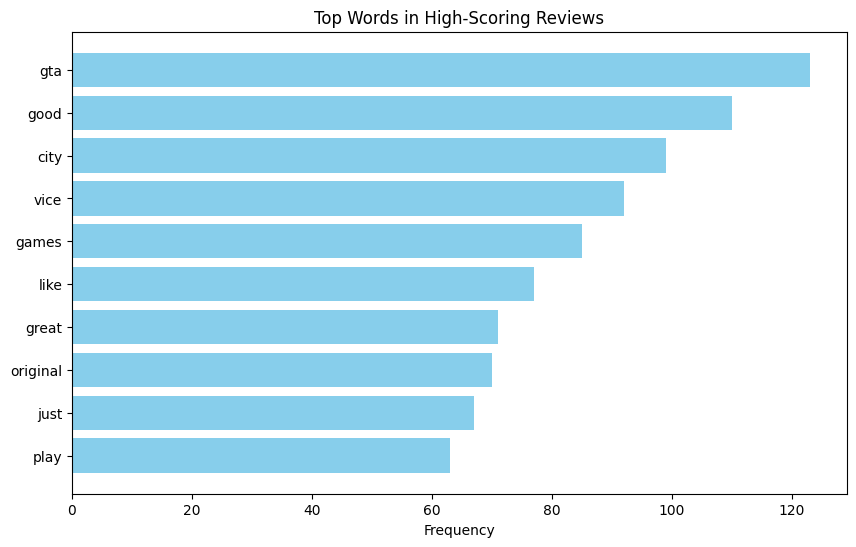

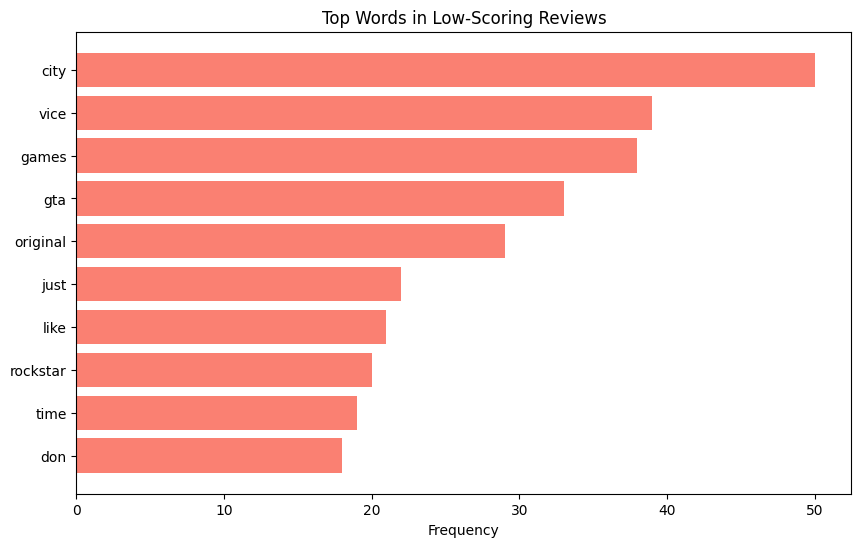

Reading with reviews-comp/reviews_49520.csv


,review,positive,neutral,negative
0,It's fun.,0.890002,0.098650,0.011347
2,combat might get a bit reperative bot overall great game runs good on low end pcs as well pretty good deal if you find it on sale kind of a classic,0.968935,0.027762,0.003303
5,One of the best looter shooters i've ever played! Much better than the 3rd one. Unlike the 3rd one when you get a legendary it takes time and you don't always get it on your first try which is great! The story line is great same with all the DLC's and Headmasters/Mini DLC.,0.988115,0.009091,0.002795
10,good game 10/10,0.965704,0.030273,0.004023
11,Real fun played it for a while,0.947589,0.048707,0.003704
14,still don't understand the parts sytem,0.006580,0.133067,0.860353
15,Yes and Yes!,0.857028,0.135089,0.007883
16,I have diabetes,0.010915,0.108291,0.880793
18,Single best game i have ever played and has made my life as a whole better,0.987696,0.010285,0.002019
19,game good,0.857312,0.127867,0.014821


,review,positive,neutral,negative
6,αυτά μαρέσουν,0.049196,0.786087,0.164717
9,Train crash vault guy live robot guy help vault guy vault guy kill big gorilla vault guy kill fire man vault guy go sanctuary vault guy make sanctuary safe vault guy save leader leader saved vault guy go help snipe guy vault guy kill snipe guy pet snipe guy cry vault guy go find big guy vault guy kill big guy army big guy acquired vault guy kill bunker guy bunker guy die leader die lady die magic lady kidnapped vault guy go find handsome guy vault guy find handsome guy vault guy hurt handsome guy handsome guy spawn big guy big guy die handsome guy die vault guy wins 10/10,0.124178,0.751971,0.123851
29,muy buen juego y tambien muy bueno su doblaje al español,0.095102,0.838406,0.066492
38,5/5,0.193528,0.624323,0.182149
42,WOULD RECOMEND,0.108150,0.790185,0.101665
57,Can devs make more games like this one? Is that so much to ask?,0.163471,0.683142,0.153387
58,Best Looter Shooter,0.138577,0.779082,0.082341
134,"[quote][i][b]SHORT REVIEW :[/b][/i] the second Borderlands keeps the same ideas of the previous chapter a frantic FPS with a lot of humour quests and items to use. Unfortunately it keeps also the repetitive formula of doing dozens of quests without interest killing thousands of enemies that are just there to fill the maps and trying to follow a storyline that falls in the boredom of cliches.[/quote] [i][b]> Gameplay ( 6.8 / 10 ) :[/b][/i] classic fzirst-person shooter really dynamic and easy to play. Like a RPG you can find many weapons of different rarities and stats you gain experience when you kill enemies and complete quests to level up and gain new skills. However [i][b]game becomes repetitive soon[/b][/i]: weapons and quests are always the same things recycled and adventure summarizes simply in ""from point A to B kill enemies loot take quest reward"" and repeat. There are many improvements with items statistics and abilities but nothing noteworthy for a new chapter. [i][b]> Story ( 4 / 10 ) :[/b][/i] storyline is pretty basic and unfortunately even if there are many characters and missions to complete is still empty and flawless like the previous chapter and there is no point to follow it. [i][b]> Aesthetics ( 6.4 / 10 ) :[/b][/i] game has a nice toon style that matches perfectly the light and crazy mood. Many areas of the game lack details and sometimes maps are too empty but there has been a nice improvement from the previous chapter especially in cities and main zones but there was needed a better work. [i][b]> Audio ( 6.3 / 10 ) :[/b][/i] sound system is on the same line as the graphic. Few music tracks are repeated until exhaustion and sound design is generally mediocre. Nothing special to hear in this game. At least the characters' dialogues are of good quality. [i][b]> Difficulty ( 5.5 / 10 ) :[/b][/i] I didn't find a real challenge in this game. Both in normal game and NG+ enemies' number and health make the game not more difficult but just more time-consuming. Few skills are notable weapons look always the same some are overpower some others are just basic; most of the quests are simply boring. [b][i][u]> Overall Rating ( 5.8 / 10 ) < [/u][/i][/b]",0.000000,0.000000,0.000000
143,Borderlands 2 – A Hilarious and Addictive Journey in Pandora Borderlands 2 released in 2012 is a masterclass in blending action humor and RPG elements solidifying its place as a beloved title in the gaming community. With its unique cel-shaded art style engaging gameplay and unforgettable characters this game offers an exhilarating experience that keeps players coming back for more. From the moment you step into the chaotic world of Pandora you’re met with a vibrant and visually stunning environment that perfectly complements the game’s quirky tone. The cel-shaded graphics give the game a distinct look making every locale—from dusty deserts to lush highlands—feel alive and dynamic. The humor is woven throughout the narrative and dialogue with memorable lin

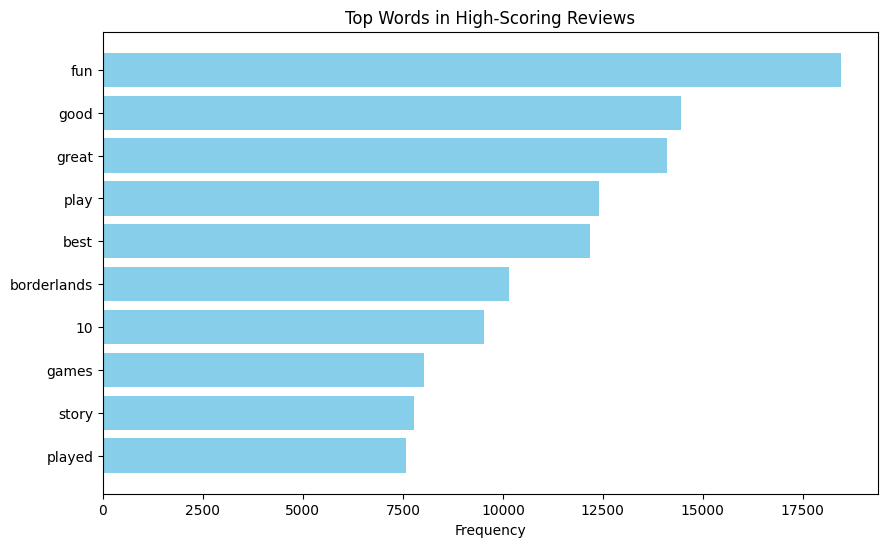

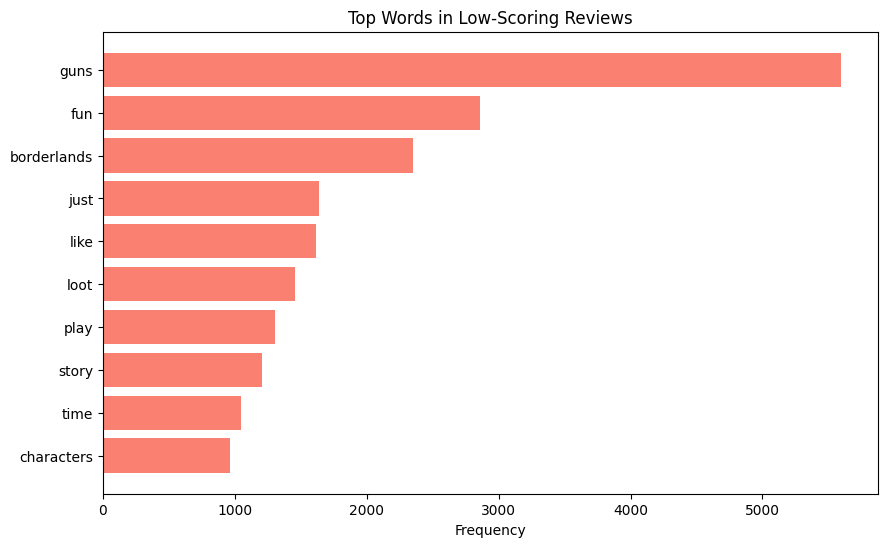

Reading with reviews-comp/reviews_409720.csv


,review,positive,neutral,negative
0,pls get that creepy little girl out of my head pls,0.004931,0.090754,0.904315
1,I've completed the main game and the Minerva's den DLC as of writing this review. The game pretty good. Better gameplay than the first the story is also as good as the first game. The DLC is a must play if you liked the main game. You'll require around 25 hours to complete the game if you're a completionist. Remember to save a LOT. I experienced a lot of crashes.,0.930430,0.056987,0.012583
3,Second Best Bioshock game. Very close to 1 but it just doesn't quite hit that bar. It's fun to lumber around as a big daddy and show peple who's boss with a big ass drill. 9.75/10,0.816466,0.135987,0.047547
13,The game was going so well. I don't usually post negative reviews and I liked the first bioshock but I was at the Siren Alley level and recued/farmed adam out of all three Little Sisters and then went to the level's boss chamber.,0.942092,0.053532,0.004376
20,Love this game it's the best Bioshock game in my opinion. Now if only it stops crashing...,0.945755,0.034858,0.019387
26,great story line.,0.867403,0.121389,0.011207
27,I've been on a Bioshock bender B2 was the only one in the series I never completed until now. While not on the level of Bioshock 1 this is still a great game with fun combat and an enjoyable story.,0.928261,0.060559,0.011180
29,I think this game is great. While it doesn't reach the storytelling heights of the previous one it more than makes up for it in terms of gameplay. The Minerva's Den DLC is fantastic and really enhances the experience. Overall I'd highly recommend this game. The only real downside is the launcher that 2K has made mandatory for all their games which is a shame.,0.909545,0.064720,0.025735
31,Absolutely brilliant,0.841729,0.133523,0.024748
38,Great game.,0.923488,0.069490,0.007021


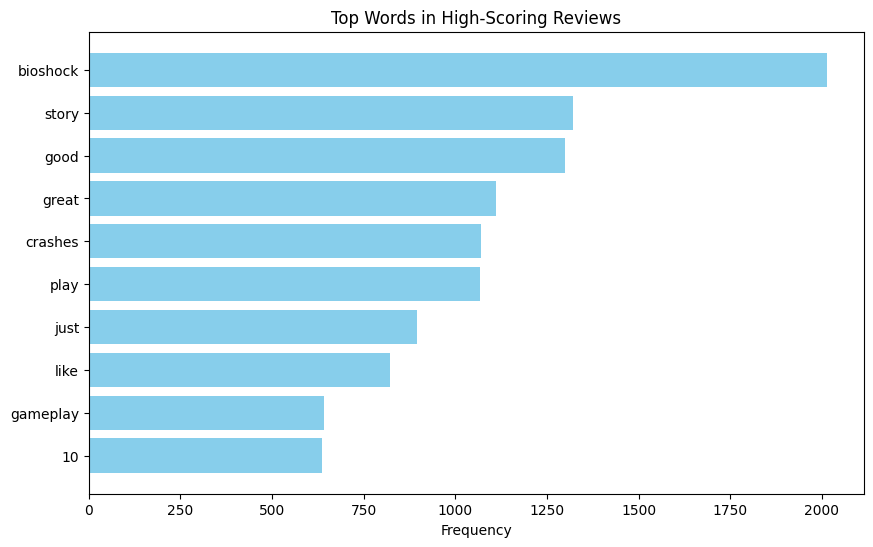

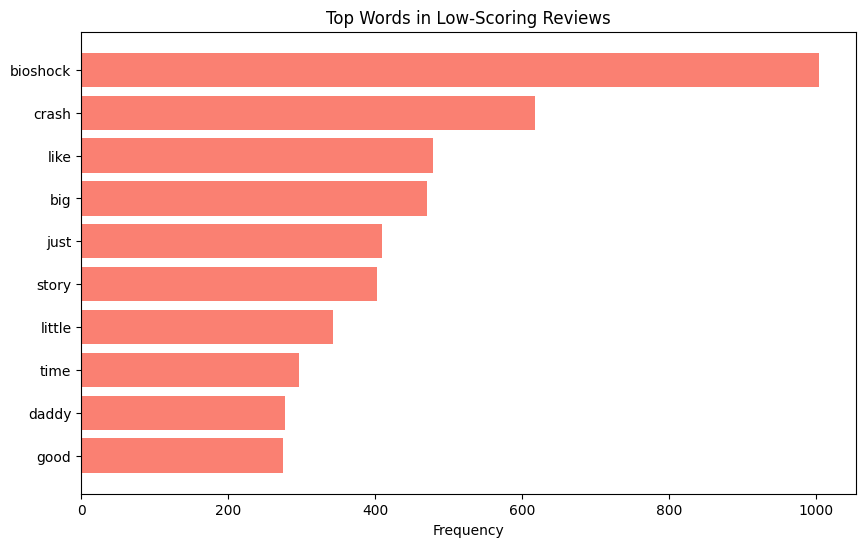

Reading with reviews-comp/reviews_1659420.csv


,review,positive,neutral,negative
4,Pretty good game reminds me of the remake tomb raider games. My first uncharted games so if took a while for the characters to click but by the end i was invested enough to be touched by the ending Worth a look,0.967323,0.028708,0.003969
5,I would consider this to be a waste of potential and an example of laziness. If the port was reversed and this game was going from PC to Consoles it would lack controller specific options and features like smoothing or aim-assist. However in this case this game has been ported to pc. Shortly after release they attempted to give us Raw-input support or something like it but mouse movement and aiming still sucks 2 years later. If the Spider-Man games can be ported to pc with raw-input and fully functional mouse movement and aiming features there shouldn't be a reason why playing this game with a mouse and keyboard should suck this bad. Fail!,0.017089,0.113180,0.869732
6,Lost Legacy gets too much hate but what you're really here for is Uncharted 4. What a game man. I wont act like it's perfect. But MAN does it get close. The game still looks jaw dropping even 8 years later. Naughty Dog just doesn't miss.,0.849831,0.118570,0.031599
7,would not let me play the second time fuck this game get tomb raider instead,0.002653,0.025738,0.971610
12,Love this game story and gameplay is really nice i could not put it down lol im going to 100% this game soon thank you SONY for these 2 amazing games,0.992367,0.005116,0.002517
13,I originally played Uncharted 4 on the PS4 and ive fell in love with this series ever since unfortunately i became ver ysad when i found out that the uncharted franchise has come to an end after uncharted 4. if you enjoyed tomb raider you will love this game IT IS A MUST PLAY!! loved the characters throughout this game from the main nathan drake to his brother samuel and the antagonist Rafe..man this game yall have to play it!,0.986404,0.010957,0.002639
14,I recommend this game the graphics and visuals are amazing. Still exploring the story line it is interesting.,0.989060,0.008909,0.002031
16,PC port is a little unstable but the game itself is a masterpiece.,0.820168,0.150166,0.029666
17,cool adventure story game,0.956139,0.041412,0.002450
18,Wonderful recreation of past civilization gorgeous imagery,0.948487,0.047001,0.004512


,review,positive,neutral,negative
0,+ Красивая картинка - физика не понравилась - затянутая история - однотипный геймплей - не дешевая игрушка,0.043232,0.853498,0.103270
15,masterpiece,0.198108,0.661647,0.140245
25,FIRE,0.174522,0.642385,0.183093
28,Wundervoll.,0.136028,0.735120,0.128852
30,juggernaut spam and when you press b to roll it goes into cover when you press b to cover you roll. When you press b to get out of cover you roll RIGHT OF THE GOTDAM TRAIN,0.067375,0.768520,0.164105
169,[h1] Uncharted: Legacy of Thieves Collection Review [/h1] [h1] Uncharted 4: A Thief's End⭐ Game Rating: 10 / 10 ⭐[/h1] What a magnificent and perfect sum up to Nathan Drake's story and series. The game captures everything you could ever ask from from Uncharted into beautiful scenery and immaculate puzzles and exploration! Being a long Uncharted fan myself of the first 3 games I finally got my chance to buy these last 2 on PC. And yes was it perfect. Normally I do not give a game a 10/10 maybe a 9.9 at the most but this one is special to me as well as is made so perfectly and well executed in every aspect that the game is just a 10. I will not spoil anything for you if you have not played it yet. But every chapter everything that happens happens with intention every scene and shot has intention when you are playing through. The camera work on the character is astonishing let alone the atmosphere design around you. Well played Naughty Dog well played. [h1] Uncharted: Lost Legacy ⭐ Game Rating: 9 / 10 ⭐[/h1] I consider this game to be the extra content DLC to Uncharted 4. Sort of the extra juice that players can experience right after finishing Nathan Drake's story. This game did well like Uncharted 4 but much shorter in length (about half as long) and a little less development on the characters and story. But still well put together for the game it is suppose to be (the main character being Chloe). You could technically play this game before playing Uncharted 4 but I would not recommend it as it is kind of in order to be played afterwards not that it would spoil anything from Uncharted 4 but you will see what I mean once you play in order. Other than that it is a 9 only because it was not as good as Uncharted 4 obviously and felt more like a big DLC but in terms of the design of the gameplay the still-stunning imagery and the great puzzles it is still a masterpiece-ish from Naughty Dog! Overall you can buy this collection on sale or not on sale and you would still get your moneys worth but it does go like 40% off pretty often so I would get it then. Either way you get a ton of content to do and the story is very long for both I would say between the 2 games doing a solid first playthrough of each easily you can accumulate at least 30 hours between the two now 100% is another conversation but still worth it.,0.000000,0.000000,0.000000
206,If Ubisoft redefined my perception of game environments Capcom of game atmosphere and FromSoftware of gameplay then from now on NaughtyDog has redefined my perception of game experience.,0.179996,0.760372,0.059632
242,'Press X to interact with cutscene' = gameplay?,0.037639,0.819053,0.143308
259,first uncharted game played gege,0.142999,0.824927,0.032073
272,Building shaders,0.138847,0.739074,0.122079


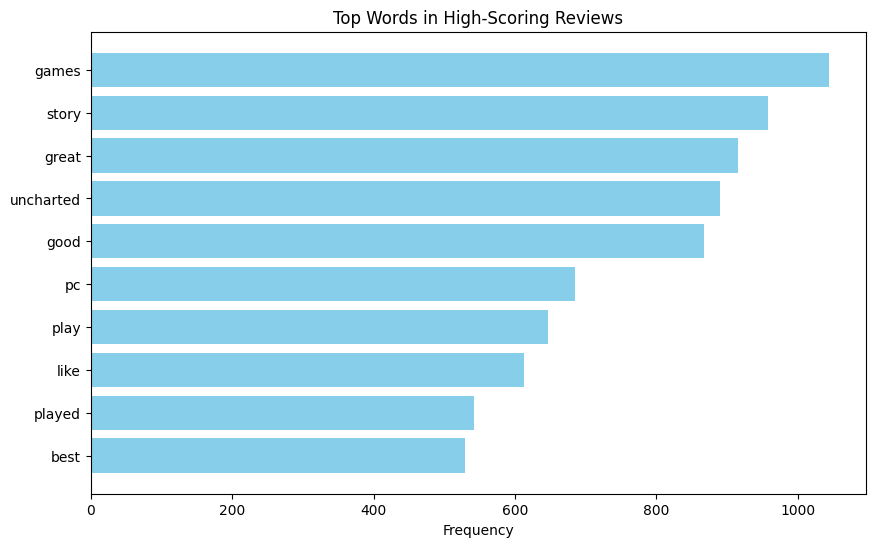

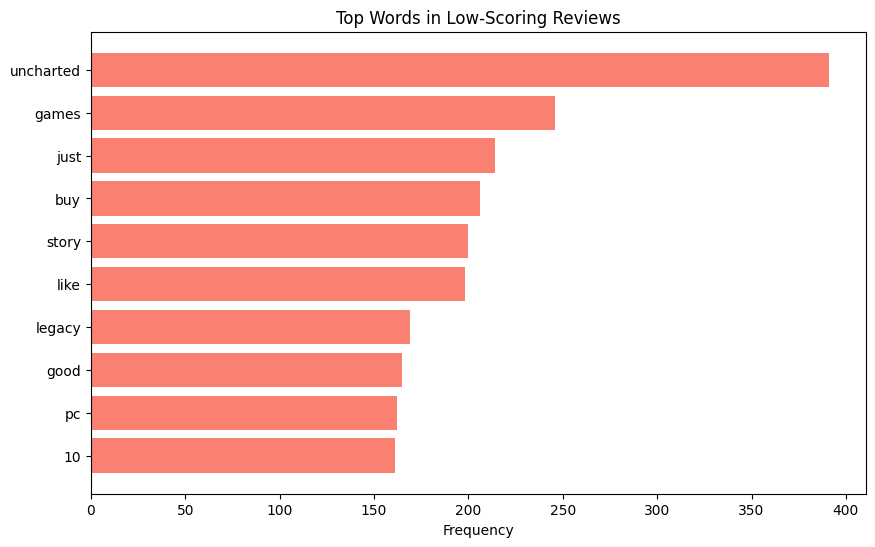

Reading with reviews-comp/reviews_2172010.csv


,review,positive,neutral,negative
4,It's one of my favorite games. It was exciting to playthrough it again after so long,0.991605,0.006604,0.001791
5,I LOVE IT !!!,0.979478,0.015085,0.005437
7,its good.,0.946083,0.047888,0.006029
8,The absolute best horror choices game around. Even if you watched a play-through playing it yourself is 100% worth it. An experience every time very in depth and complex. Absolutely love it and recommend! :) The additions to the remake I also really love excited for what comes next with this universe...,0.992010,0.006016,0.001974
9,I adore this game so very much I hope a sequel comes out.,0.989907,0.007882,0.002210
12,Amazing. Get it!!! I never played the first iteration way back because of real life but happy there was a remake of this game. My first play through I just finished now and loved it and had a wonderful fun time! I hope they make an Until Dawn 2!!! Woo woo! Heck yah!!!,0.989868,0.007776,0.002356
13,"Highly recommend avoiding this ""Remaster"" The game crashes more than any game I've ever played unless it's on the lowest res possible and even then runs slow laggy drops frames and potentially crashes. Also I guess it ran in the background somehow because it claims I have 10 hours on it when I couldn't even get past the first scene and spent an hour or two adjusting settings trying to make it function Very disappointing",0.005739,0.035987,0.958274
18,I love everything about this game my favourite part is getting to know the chernobyl monsters!,0.991154,0.006024,0.002822
19,Good remake to one of the best horror games back in the day.,0.957000,0.039565,0.003435
21,Game plagued with issues graphical glitches frame rate drops freezing when entering new areas or upon picking up items or going into menus. These are just the technical issues. O death - signature theme of Until Dawn and Until Dawn-likes (dark pictures) has been removed. A lot of songs and OST have been removed and/or changed around. Camera angels have mostly been replaced with over the shoulder camera. Scenes have been reedited re imagined added in and some have been removed altogether. Running has been removed as a control option. You now run only in specific areas. You are now forced to walk in most places. New areas have been added to the game (?) it seems or at least I don't remember some of the side locations and it seems they have added in cut content/dialogue. I'm only around the half way point so I'll update on my final thoughts on all of this. So far I'd rate it poorly due to the technical issues alone. It's been 15 days since the last patch and the game only recently came out. I fear that most of these significant issues may never be fixed.,0.013264,0.141979,0.844758


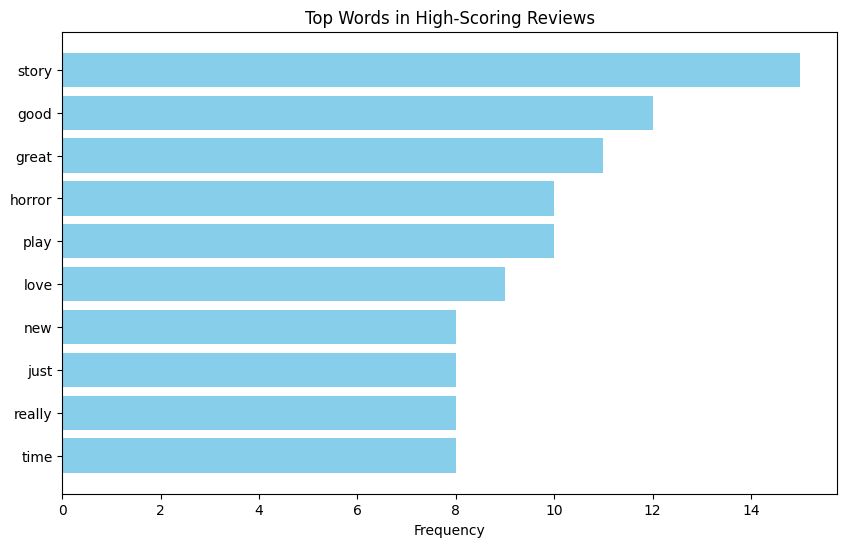

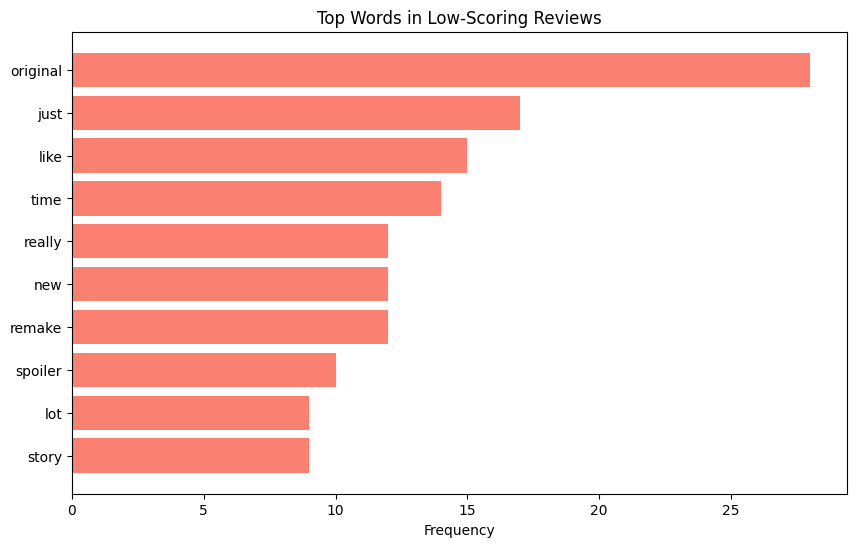

Reading with reviews-comp/reviews_1817190.csv


,review,positive,neutral,negative
0,Supah Good.,0.867392,0.125826,0.006783
1,give me a refund this shit laggy asf,0.003355,0.020415,0.976230
2,Love this game!!!,0.988784,0.008202,0.003013
4,While definitely shorter than it's predecessor it's still an enjoyable experience with the newfound abilities of Miles over Peter.,0.931682,0.065003,0.003315
5,it good,0.842941,0.138377,0.018682
7,this game is super fun!!!!!!!!!!!,0.990852,0.006944,0.002204
11,From the moment players swing into the neon-lit streets of Harlem the graphics of Miles Morales are nothing short of stunning. The vibrant colors dynamic lighting and intricate details immerse you in a wintery New York City filled with Christmas cheer and urban grit. The game excels in environmental storytelling; every district feels alive and bustling making the city itself a character within the narrative. The attention to detail in the character designs particularly Miles' sleek and distinctly different suit helps set a youthful tone that reflects his coming-of-age journey.,0.966898,0.031696,0.001406
12,Great game with a great story. Combat in this sequel was even more satisfying than in the first one traversal was really fast responsive and satisfying too. Can't wait to play Spider-man 2 in January. GG,0.992003,0.006631,0.001366
14,kinda short but really good get it on sale,0.964689,0.033075,0.002236
15,I love how this game looks and plays looks better than Spiderman 1 did on PS4 maybe one day I'll revisit the first game,0.990545,0.007643,0.001812


,review,positive,neutral,negative
44,Peak gaming fr,0.145422,0.763914,0.090664
56,It's the same as the other spiderman game with a different skin and different cutscenes. i leave it up to you if thats good or bad.,0.160082,0.711486,0.128432
66,black spiderman,0.137277,0.790128,0.072594
75,ဒီဂိမ်းအကြောင်းကို ပြောဖို့ဆိုရင် သူ့အရှေ့က Marvel's Spider-man ကို မဆော့ထားပဲနဲ့ ပြောဖို့ အဆင်မပြေဘူးထင်တယ်။ Story ကလဲ တိုက်ရိုက် အဆက်ဖြစ်ပြီးတော့ မြေပုံတွေ၊ Combat တွေ၊ Moveset တွေကလဲ အများစုက အတူတူပဲမို့ ၂ ခုယှဉ်ပြောမှပဲ အဆင်ပြေပါလိမ့်မယ်။,0.000000,0.000000,0.000000
108,blackman,0.158931,0.661071,0.179998
119,Ahoj,0.195379,0.640515,0.164106
126,the exagerated swagger of a black teen,0.127048,0.820796,0.052157
127,swishswish,0.086142,0.801600,0.112259
134,spiderman again but shorter get it on sale,0.116751,0.823217,0.060033
141,he's gonna do his own thing,0.183939,0.757365,0.058697


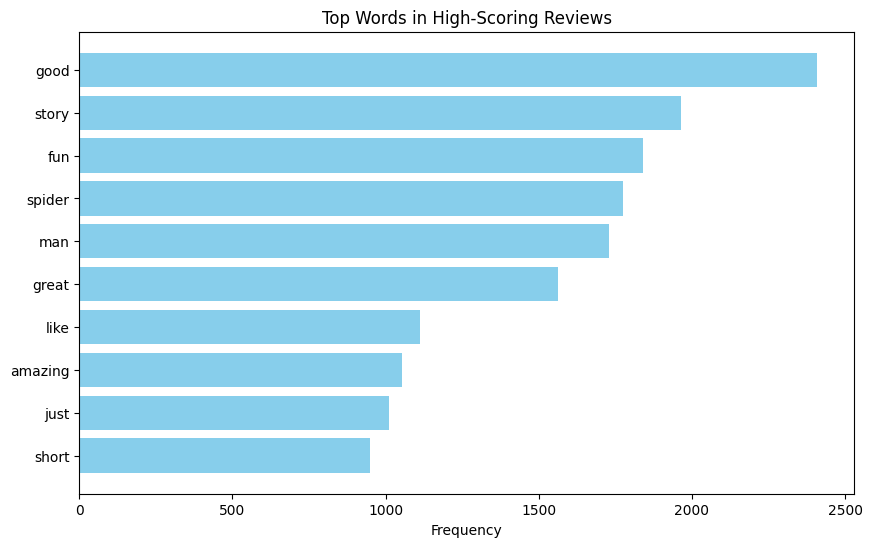

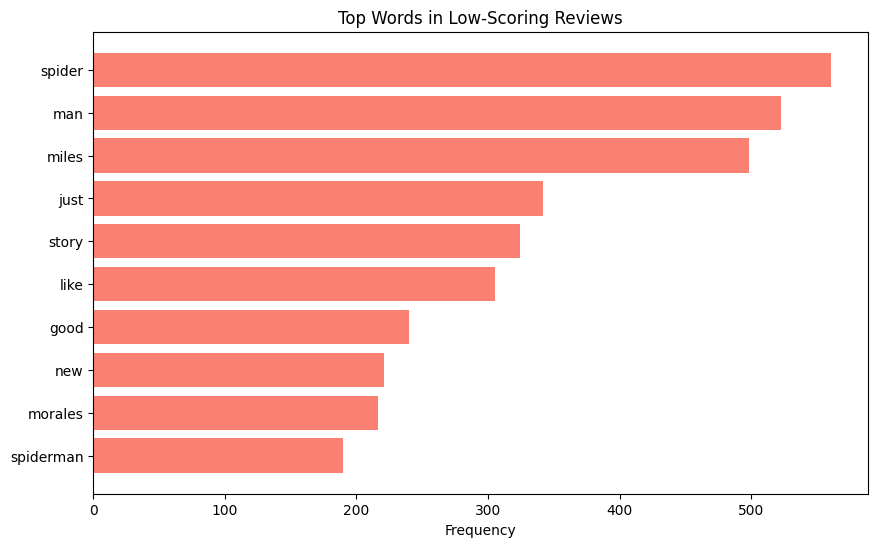

Reading with reviews-comp/reviews_2322010.csv


,review,positive,neutral,negative
1,This should not be considered a video game... ABSOLUTE CINEMA!!!!!! 10/10,0.003050,0.024940,0.972010
2,So good. Really well optimized (shocking well optimized for Steam Deck) and the story is just *chef's kiss* incredible.,0.987566,0.010256,0.002178
3,Well what I do think about the game is that the fighting scenes the family bonding and the drama were good but the game didn't surpass God of War 2018 which I still think is the best and my favorite in my opinion. [url=https://steamcommunity.com/groups/REVIEW-STARS] REVIEW STARS [/url],0.919997,0.072194,0.007809
7,It's God of War. Expect a lot of simple puzzles and bosses with a few tricky ones in between. The story stumbled over it's feet in some places but managed to tell an over-all satisfying tale. Some of the scenes were emotion evoking taking you back out of the fast-paced fight from just moments before. Over-all the scenery and detail on the characters down to the animations is top notch. Many times I felt myself in awe of my surroundings from the grandeur of the mountains to the stone work adorning walls.,0.943334,0.051357,0.005308
10,great game,0.926472,0.063943,0.009585
14,Awesome Sauce,0.916375,0.077116,0.006510
15,Fun gameplay good story and insane graphics definitely worth the buy 👍🏽,0.972925,0.024749,0.002326
18,Amazing Games,0.861559,0.124318,0.014123
21,Game won't boot at all support not helpful. I'm not the only one with issues. Will change review when it's fixed.,0.020218,0.145749,0.834033
22,If you liked the first game from 2018 this is more of the same. In the best way possible.,0.869046,0.122787,0.008167


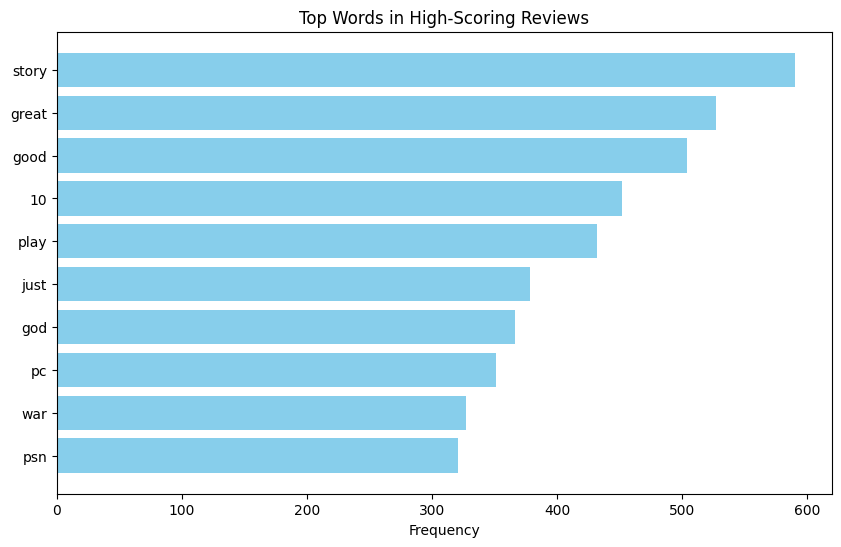

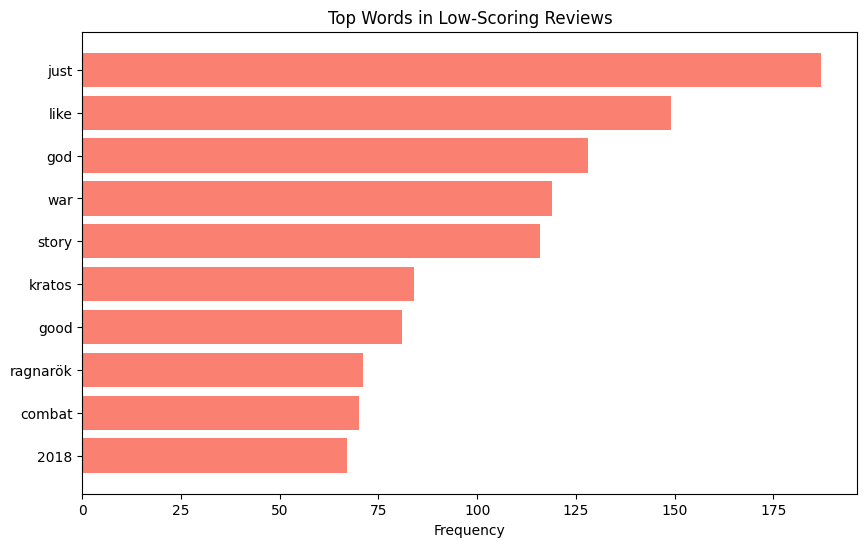

Reading with reviews-comp/reviews_1888930.csv


,review,positive,neutral,negative
0,A moving story line incredibly beautiful scenery and graphics simple enough to learn and play. Would very highly recommend and I can't wait for Part 2 to come to PC,0.991178,0.007166,0.001656
1,This is quite possibly my favourite game of all time. I saw the show first but either or there were a lot of differences which made it interesting. Its cinematic and it's story is incredible. Graphics: 9/10 - a few issues here and there probably due to my pc Story: 9.5/10 - A few really small issues but its an incredible story Gameplay: 7/10 - some puzzles feel forced and tedious but as a whole good gameplay Environments: 8.5/10 - as I said some puzzles just feel forced due to environmental construction - but on the whole incredible construction of environments Overall: 9/10 - I would recommend for anyone,0.970559,0.023854,0.005588
4,First of all the graphics look incredibly stunning.. the characters feel so alive with their movement and facial expressions - that makes the story hit really deep because the characters just seem real,0.987872,0.010340,0.001788
8,Best game in the world,0.967851,0.027795,0.004355
10,MILF man i love fthelastofus,0.976583,0.019863,0.003554
11,one of the best story games,0.979673,0.017495,0.002832
16,"PC games are kind of plagued by various aspects like monetization live service schlop multiplayer... Apparently we as PC players NEED to be on PvP otherwise yeah something is ''wrong"" with us or it's them but no this game basically is a singleplayer hidden gem that looks really beautiful has some really cool level / map / world design as well as some impressive and I find engaging storytelling. It runs really great and plays very good. It's a action/adventure game with some nice action and worldbuilding like storytelling and what took me really by surprise is how good the animations are and especially facial animations. All of these things that I've mentioned are really well done and I think this has nudged me personally towards checking out more console games that are so well ported to PC like this one is. I understand and acknowledge by the way that my review here is based on a very short playtime but you know what they say about impressions of a person? First impressions always last the longest so this sort of philosophy I also extend to games and gaming as well and if I am wrong in terms that if the game disappoints me later on I can and will adjust my review based on observations later on but for now this game is solid and like I've said it's really good I think. ""A strong initial impact can shape our entire perception of a game."" This is a special game because it has a few if not many aspects about it that I basically can't remember last singleplayer game I played incorporated them and the emphasis lies here on sort of realism or plausibility like ""plausible realism"" in which the game portrays its world protagonists and antagonists and from what I've seen and now experienced a few hours in I got to say it has made me want to come here and shed a few words about it so. Here we are. Enjoy and oh yeah. Gives us more of these pleasies. Zombie survival action-adventure games but especially single player (stealth) games because I for one yearn for more of such games.",0.858424,0.125477,0.016099
18,pls play this before u watch the show its so good i have played it like 5 times,0.987132,0.010944,0.001924
19,Now I understand why fans are extremely disappointed with the politically correct TLoU Part 2.,0.002745,0.057232,0.940024
22,Zombie/post-apocalyptic games are my thing there's no genre I enjoy more and that's been the case since i was a kid playing Undead Nightmare. I wanted this game when it came out in 2013 but I grew up on 360 had an xbox one and jumped to pc. I waited over 11 years to play this game avoiding all spoilers and even gameplay. Simply put it was more than worth the wait...,0.920467,0.064370,0.015163


,review,positive,neutral,negative
33,its a classic stealth through or guns blazing up to you but the story is where your focus should be the character's and the world building,0.116165,0.839943,0.043892
136,pls part 2 op pc,0.157830,0.821984,0.020186
152,They need to make a online co-op using the last of us format,0.148438,0.833474,0.018088
157,[h3]Great Game awful Port.[/h3] The Last of Us is in my opinion one of the best games ever made. I played this game a lot back on the PS4 but even now i'm playing it like for the first time. It just hits hard storywise and the gameplay is really well done too. It's just perfectly done all around. Why am i giving this game a bad rating? Simply because i can't accept the fact that such a good game was ported in such a bad state and even after a whole year since release it's still broken in some aspects. The reviews are all postive so i want to give these things some attention so that some of you'll be warned about those things. Be ready to troubleshoot this game for a few hours before you can actually start to play it. Firstly some soundeffects are completely missing if you don't play around in the settings after [b]every single start.[/b] If you don't do that then there's a high chance that you won't hear some things in the cutscenes like Footsteps or character interactions with certain items in those cutscenes. [b]In that case you'll have to start the game change the Audio Compatibility from Spatial to Traditional or vice versa restart it and then play the game.[/b] (That fixed it for me at least) [i]There's literally a TLoU Faq Site on Naughty Dog's website for most of the troubleshoots for this and many other issues. Instead of actually fixing them with a patch they just showed us how to play around the settings to hopefully fix them temporarily ourselfs. Well better than nothing i guess.[/i] Anyway the next huge problem are the crashes. So many crashes... I honestly don't know what stopped them but the game stopped crashing for now despite me not doing anything. It crashed after every single level transition. I never had any crashes in any other game before not even in demanding AAA games. I actually wanted to refund this port but then it stopped so now i can (hopefully) finish this game without these problems. The Performance could be better too. Anyway i'm happy that now i can fully enjoy the game (despite a few graphical bugs here and there) but still these things should've been fixed a long time ago especially the crashes since many other people suffer from the same problems too. And having to restart the game multiple times at every session because of the audio issues is annoying too.,0.000000,0.000000,0.000000
161,Specs:,0.147735,0.735266,0.117000
170,"It's an interesting time: as soon as I could afford to buy a PlayStation for its exclusives those very exclusives started making their way to PC. Nevertheless this game convinced me to buy a DualSense controller. Although the controller itself is a debatable purchase [i](the haptic feedback is cool but maybe not worth that price)[/i] the same can't be said for this game. Even though the story and plot were not new to me—I’ve played through it a couple of times on YouTube and there was also a TV series recently—but damn it feels like the release of such games changes the timeline to ""before"" and ""after"" similar to each release of a GTA game but in terms of narrative script characters depth detail... You get the idea. I want to immediately praise the game for its reflections something that nowadays you can count on one hand! It's a long-lost technology. Overall the game of course looks stunning. It seems to have some of the best lighting work I've seen or at least this game made me notice how the light functions. The darkness is ominous and oppressive particles scatter and react to the character's movements. Large-scale locations are so screenshot-worthy that you want to make them your wallpaper. The sound design is superb and 

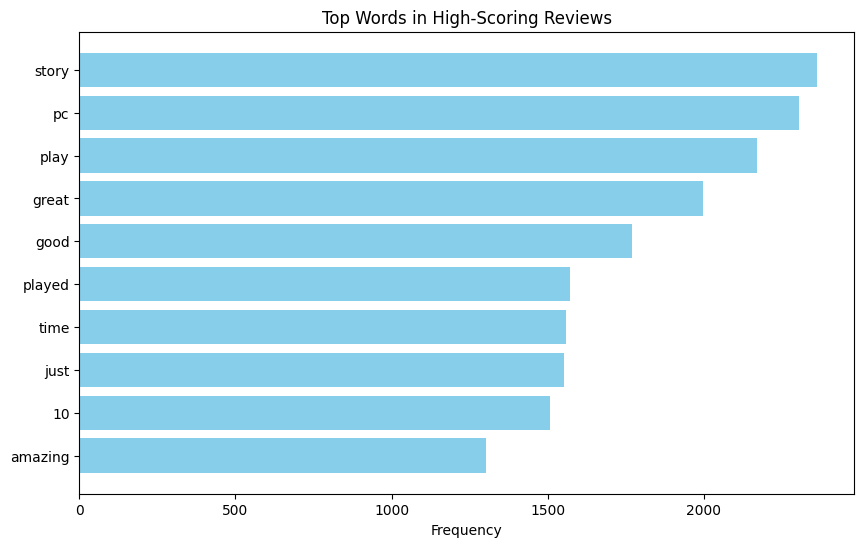

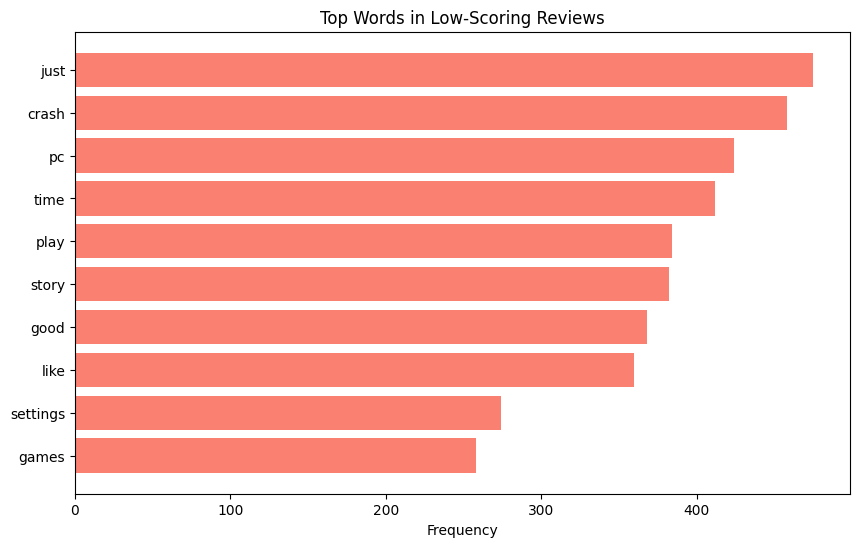

Reading with reviews-comp/reviews_2215430.csv


,review,positive,neutral,negative
2,Played this on PS4 and it was totally meh. This is such a better experience playing at 60fps. Great game.,0.963453,0.030065,0.006482
3,Indirectly I've made my best efforts since this released on PS back then to not know anything about this game; but ever since I picked it up on sale and played it through I'm so glad that I did.,0.965406,0.030762,0.003832
6,This is the kind of game you wanted from assassins creed. It's a fantastic open world game visually stunning incredibly fun to play whether you choose to progress as a noble warrior or a stealthy ninja and a very immersive representation of feudal Japan. The main missions story is unbeliveable making u get stuck to the game just wanting to keep progress through it. 10/10 game.,0.940668,0.049331,0.010001
7,This is my favorite game of all time good story good combat and endless content.,0.990752,0.007441,0.001807
8,The game your girlfriend warned you about...worth the money - one time purchase ♥,0.879378,0.112846,0.007776
9,Game is fire,0.807071,0.171148,0.021781
10,One of the most fluid and beautiful gaming experiences I have had since Mass Effect 2 or Halo 3. Superb in story construction overall fluidity and cohesion of game. It is dynamic in the least and a total masterpiece,0.983633,0.014465,0.001902
12,Fantastic game good story!,0.980209,0.017052,0.002738
15,It's awesome,0.976807,0.020689,0.002504
18,its fun,0.879832,0.107439,0.012730


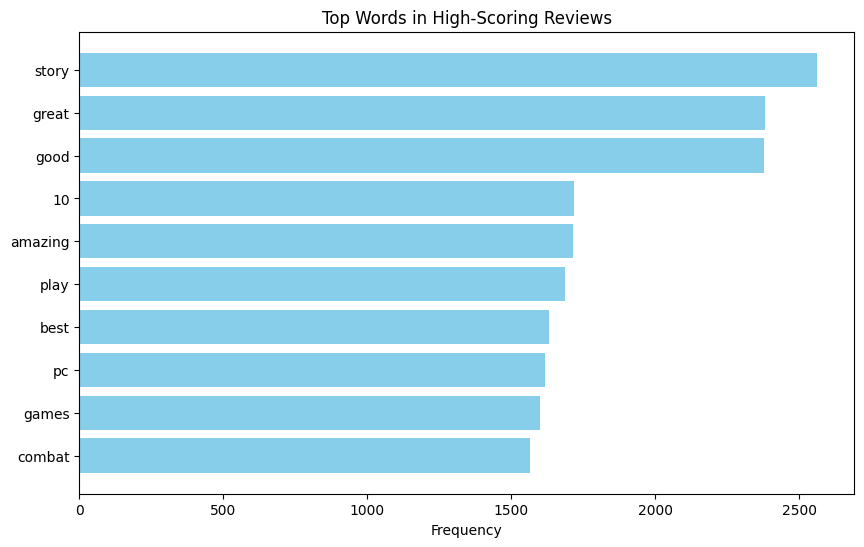

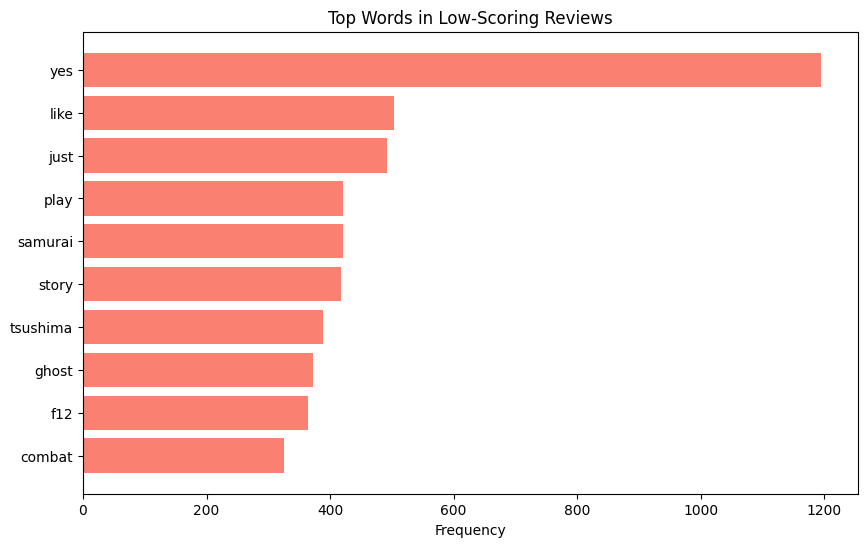

Reading with reviews-comp/reviews_1174180.csv


,review,positive,neutral,negative
0,it good game,0.908402,0.082794,0.008804
5,gay ass retarded fucker bitch game,0.004026,0.018886,0.977088
6,Game is much more enjoyable once you are able to just roam.,0.934676,0.058092,0.007232
7,this game is peak cinema,0.901743,0.090816,0.007441
10,"I love walking into shops and ""accidently"" rob them.",0.840431,0.126897,0.032673
11,i love my horsey and my horsey love me,0.985352,0.012724,0.001924
13,An absolute masterpiece of storytelling and world-building. Every detail is meticulously crafted and the world feels alive. The pacing can be slow but it’s worth it for the immersive experience. One of the best open-world games ever made.,0.983953,0.013761,0.002286
16,Amazing game rockstar never fails to deliver a masterpiece.,0.976456,0.019989,0.003556
19,Best Just Best Game Everything Is Perfect Even Though I Am Horror Game Player This Is My Favourite Game No Game Will Beat This Best <3,0.966421,0.029733,0.003846
20,10/10 beautiful story graphics everything,0.970212,0.025616,0.004172


,review,positive,neutral,negative
9,---{ Graphics }--- ☑ You forget what reality is ☐ Beautiful ☐ Good ☐ Decent ☐ Bad ☐ Don‘t look too long at it ☐ MS-DOS ---{ Gameplay }--- ☑ Very good ☐ Good ☐ It's just gameplay ☐ Mehh ☐ Watch paint dry instead ☐ Just don't ---{ Audio }--- ☑ Eargasm ☐ Very good ☐ Good ☐ Not too bad ☐ Bad ☐ I'm now deaf ---{ Audience }--- ☐ Kids ☑ Teens ☑ Adults ☐ Grandma ---{ PC Requirements }--- ☐ Check if you can run paint ☐ Potato ☐ Decent ☑ Fast ☐ Rich boi ☐ Ask NASA if they have a spare computer ---{ Game Size }--- ☐ Floppy Disk ☐ Old Fashioned ☐ Workable ☐ Big ☑ Will eat 10% of your 1TB hard drive ☐ You will want an entire hard drive to hold it ☐ You will need to invest in a black hole to hold all the data ---{ Difficulty }--- ☐ Just press 'W' ☐ Easy ☐ Easy to learn / Hard to master ☑ Significant brain usage ☐ Difficult ☐ Dark Souls ---{ Grind }--- ☐ Nothing to grind ☐ Only if u care about leaderboards/ranks ☐ Isn't necessary to progress ☑ Average grind level ☐ Too much grind ☑ You'll need a second life for grinding ---{ Story }--- ☐ No Story ☐ Some lore ☐ Average ☐ Good ☐ Lovely ☑ It'll replace your life ---{ Game Time }--- ☐ Long enough for a cup of coffee ☐ Short ☐ Average ☐ Long ☑ To infinity and beyond ---{ Price }--- ☐ It's free! ☐ Worth the price ☑ If it's on sale ☐ If u have some spare money left ☐ Not recommended ☐ You could also just burn your money ---{ Bugs }--- ☐ Never heard of ☑ Minor bugs ☐ Can get annoying ☐ ARK: Survival Evolved ☐ The game itself is a big terrarium for bugs ---{ ? / 10 }--- ☐ 1 ☐ 2 ☐ 3 ☐ 4 ☐ 5 ☐ 6 ☐ 7 ☐ 8 ☑ 9 ☐ 10 ---{ Author }--- ☑ https://vojtastruhar.github.io/steam-review-template,0.000000,0.000000,0.000000
15,Tried to make a review in the end I did,0.132005,0.802860,0.065135
24,yiha,0.158723,0.669685,0.171592
31,Masterpiece.,0.174757,0.753087,0.072156
70,artur jon hosa ditch liney javyer sein bil and portson,0.035820,0.798238,0.165942
78,goat story game,0.133811,0.758097,0.108091
81,[h1]Red Dead Redemption 2: More Like Red Dead Regression[/h1],0.071746,0.732388,0.195867
90,Pinche juego todo epiko hace que se me paren los pelos de los huevos,0.079871,0.859590,0.060539
99,Horse,0.128741,0.709984,0.161275
102,>Ride into Town,0.061836,0.903271,0.034892


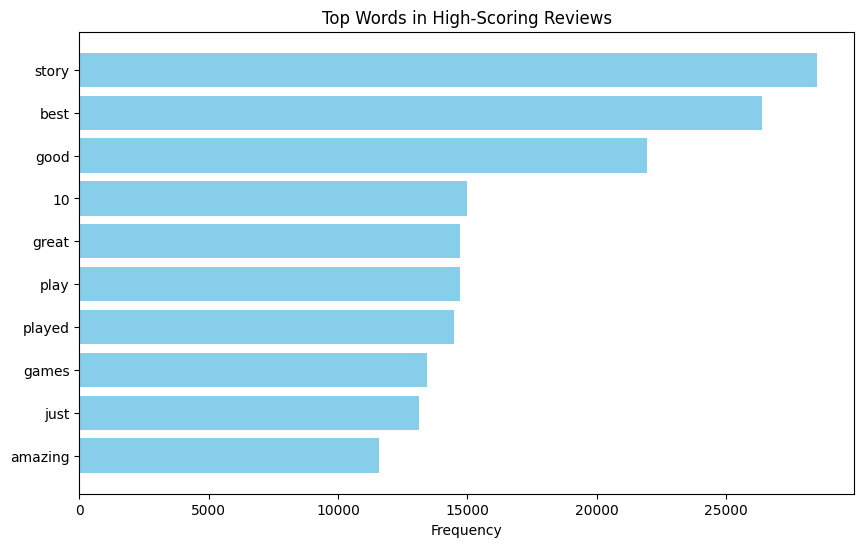

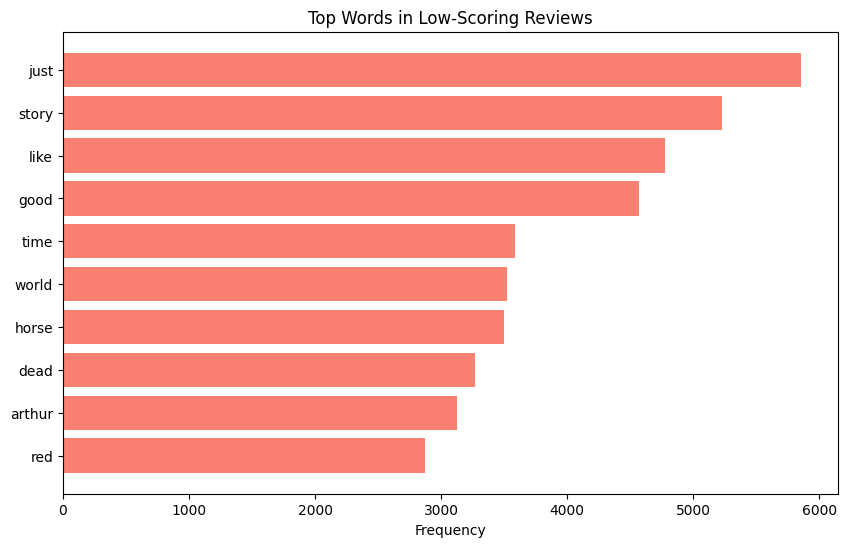

Reading with reviews-comp/reviews_409710.csv


,review,positive,neutral,negative
1,First playthrough in 2024. Amazing game. I didn't realize that Prey borrowed several things from Bioshock like photographing and fabricating items.,0.900656,0.086730,0.012614
2,Loved the gameplay and the slow reveal of revelations.,0.962669,0.032671,0.004660
3,Perfect game!,0.964603,0.031361,0.004036
5,a classic in my book. one of my first games i every got for my ps3 when i was younger and the remaster really tackles it well. a game i tell everyone to pick up at least once. 10/10,0.969621,0.028623,0.001756
6,cool game,0.937082,0.058686,0.004232
8,The best Bioshock game. So fun great story I can't NOT hate this game. 10/10,0.978999,0.013055,0.007946
9,CRASH CRASH CRASH.... I would LOVE to play through this again. But every time you reach the loading screen as the submersible arrives at Rapture it crashes without fail. Looking at the reviews there are tons of people who have had crashing issues for ages. What a shame 2K have just completely ignored it...,0.036029,0.131854,0.832117
10,I'm really enjoying this game would recommend it to anyone,0.990945,0.007529,0.001527
11,Good game worth 30-40$ maximum maybe worth it to pay more than that If you have alot of money me I am poor and had the game on discount lower than 30$ and felt happy about the experience for the price better than many new game welldone remaster,0.896629,0.087367,0.016004
12,This is my favourite game of all time. FPS combat with a variety of weapons and powers. World building and story is unique unlike anything you've ever experienced. Linear in you explore locations and as the story progresses you can move to other locations.,0.977028,0.020752,0.002221


,review,positive,neutral,negative
16,Old is gold.,0.151507,0.673984,0.174509
28,Не стареющая классика.,0.060946,0.764440,0.174614
34,L'histoire était assez ennuyeuse alors j'ai traduit le jeu en français c'est soudainement devenu beaucoup plus intéressant et je l'ai terminé ! Un jeu agréable.,0.097905,0.747410,0.154684
41,Harvest,0.166135,0.671569,0.162297
43,یارییەکی زۆر بە تام و چێژ بۆ سەردەمی خۆی، بۆ هەمان کاتی ئێستاش هەر خۆشە، ڕاستی شێوازی ئەم یاریەم زۆر بە دڵە، کە پێویستە ئەم یارییە تاقی بکرێتەوە، بەڕاستی شایەنی تاقیکردنەوەیە. (٨.٥/١٠),0.027993,0.817995,0.154013
45,⠀,0.179183,0.653071,0.167746
51,Masterpiece.,0.174757,0.753087,0.072156
52,would you kindly step on my balls,0.054862,0.759768,0.185370
61,3spooky5me,0.091105,0.711946,0.196949
68,this happened to my friend tom one time,0.061776,0.814000,0.124224


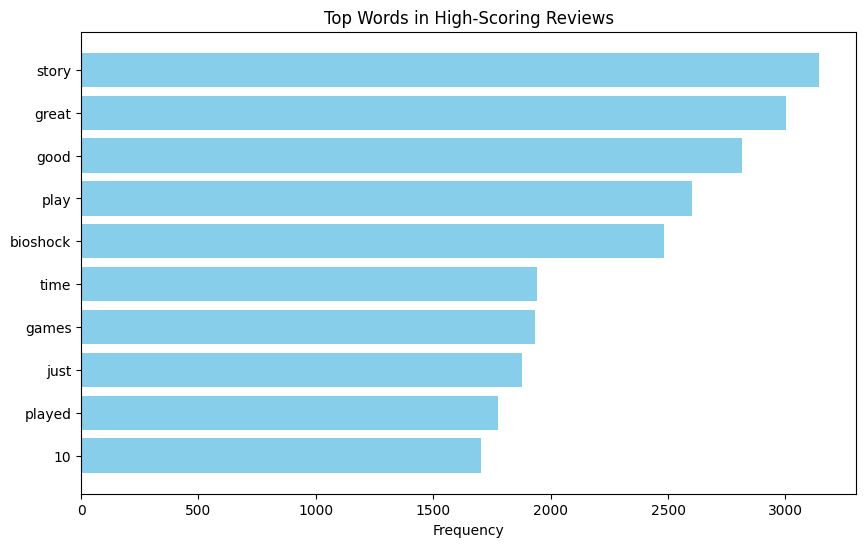

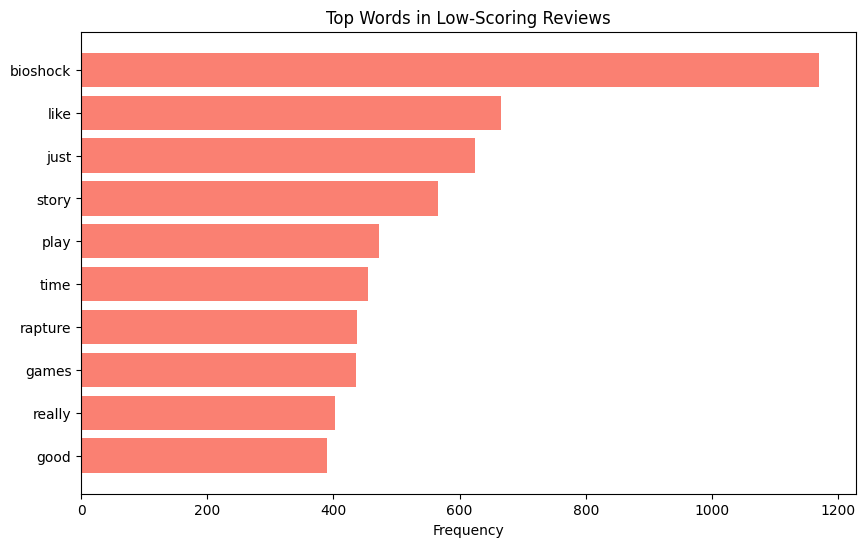

Reading with reviews-comp/reviews_1593500.csv


,review,positive,neutral,negative
1,I enjoy the open world adventure experience,0.973039,0.024945,0.002016
2,love it,0.896267,0.079559,0.024174
4,Cracked game. As someone who almost never buys games this was 100% worth it.,0.893042,0.089965,0.016993
5,Aged well still very addictive to play in 2024. I am waiting for Ragnarok to go on sale before i buy that one as well - which ive heard is even better.,0.943210,0.050603,0.006187
6,i like it :),0.974130,0.023823,0.002047
10,“I killed many who were deserving and many who were not.”,0.009746,0.136551,0.853703
13,Amazing game I 100% recommed it,0.980218,0.017292,0.002490
14,Having played most of the God of War games as a child on PSP I can confidently say that this is God of War as you remember it—but fully reimagined for a new era. It’s not just a rehash; it’s true development. From the first moments you’ll sense that familiar feeling: solving puzzles battling enemies and collecting upgrades. But this time it’s a richer deeper experience. As a fan of open-world RPGs I’m thrilled to say that the developers have done a fantastic job making this feel like a true RPG without losing the heart of what makes God of War unique. Give it some time to pull you in; you won’t regret it. This game is an emotional journey right down to its tear-jerking ending. Simply amazing.,0.982194,0.015354,0.002453
16,Great story great visuals and art direction great acting great writing (when outside of combat or a puzzle [can boy please shut up]) and mythology. You gotta love mythology. The Jörmungandr reveal still gives me chills. I don't know how this won GOTY over RDR2 but it's a great game none the less. Highly recommend :),0.983000,0.013044,0.003956
18,The graphics are still Playstation like but over all a very solid game. Highly recommend it.,0.973621,0.023936,0.002443


,review,positive,neutral,negative
15,Orangutangabangin',0.156822,0.740021,0.103156
58,masterpiece,0.198108,0.661647,0.140245
62,50 doları bastım bir daha oynadım,0.062980,0.739546,0.197474
82,✔,0.180086,0.639214,0.180700
89,God of Jorts,0.097011,0.762843,0.140147
144,Kratos is single im availiable.,0.129876,0.799877,0.070247
183,Sony published so no just sail the seven seas.,0.052279,0.793729,0.153993
205,ну первые часы скучно но когда прокачался даже интересно стало моя жидовская сторона ждет скидки на рагнорек,0.049680,0.836239,0.114080
226,This is a heavy metal album but as a game.,0.113922,0.831933,0.054145
232,Masterpiece,0.147427,0.747427,0.105146


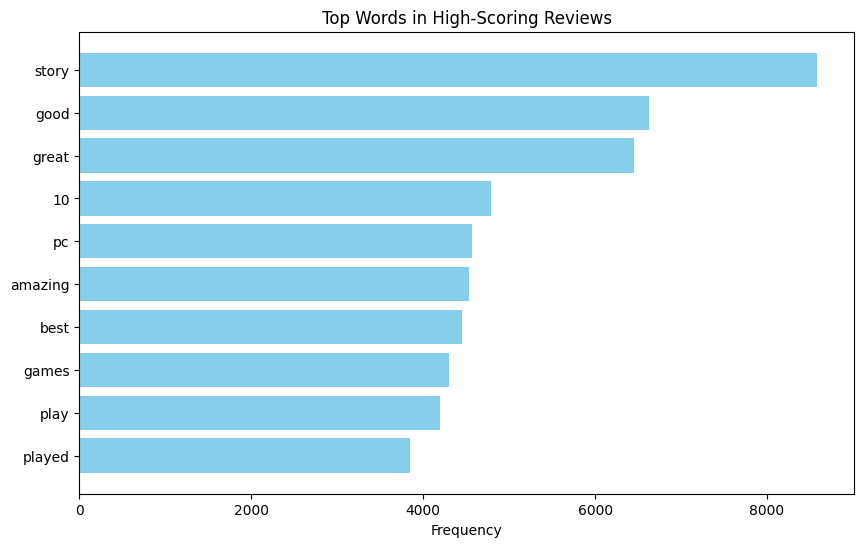

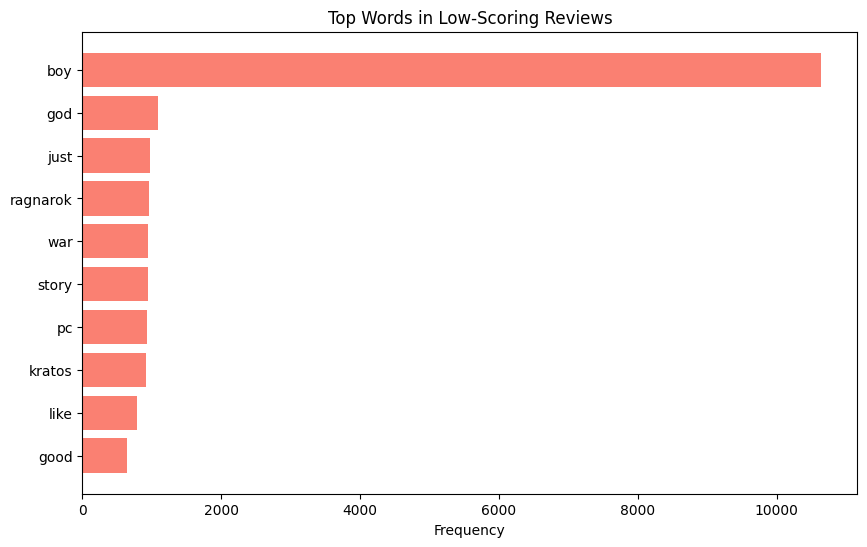

Reading with reviews-comp/reviews_729040.csv


,review,positive,neutral,negative
0,There ain't no rest for the wicked money don't grow on bees!,0.013068,0.160016,0.826916
1,This was the first borderlands and i have enjoyed it.. if you were only going to buy 1 of the series i would recomend borderlands 2 but this one is the start of the whole story so well worth a play..,0.978844,0.019050,0.002106
2,doesn't work. launcher is broken. co-op is broken due to lag and rubber banding. game crashes on alt+tab. says it's on 24hz when it's 120hz. voice mic audio in-game is broken - apparently you have to edit the config. might be just me but DPI was way too high. it's a bit outdated ofc - not really enhanced per se if you wanna get real technical. Crouch can obv be changed from C to Ctrl. would have been nice if they remade it by utilizing Borderlands 3 features. imho,0.022508,0.142459,0.835034
3,good game,0.926890,0.064623,0.008486
4,Fun Co-op game play that is exactly what a looter shooter should be...,0.883156,0.106689,0.010155
5,This game is fun even the first part of the seires plot. The DLC is mostly nice. The only bad thing about it is that it only has one single fast travel stations. Every time you start playing you need to cross the whole map again and again.,0.869970,0.095481,0.034549
6,This is an absolutely amazing game... I was always distant from it back then due to the graphics but I am glad I gave it a chance. It does get pretty easy closer to the end tho.,0.979406,0.016107,0.004486
9,Replaying this game and trying to 100% has brought back nostalgia. Outside of the memory leak FPS bug I have fallen in love with this game. I can not wait to replay the whole franchise again!,0.985432,0.011158,0.003410
11,great game,0.926472,0.063943,0.009585
12,Game frequently crashes and performance slowly degrades while playing,0.002287,0.033418,0.964295


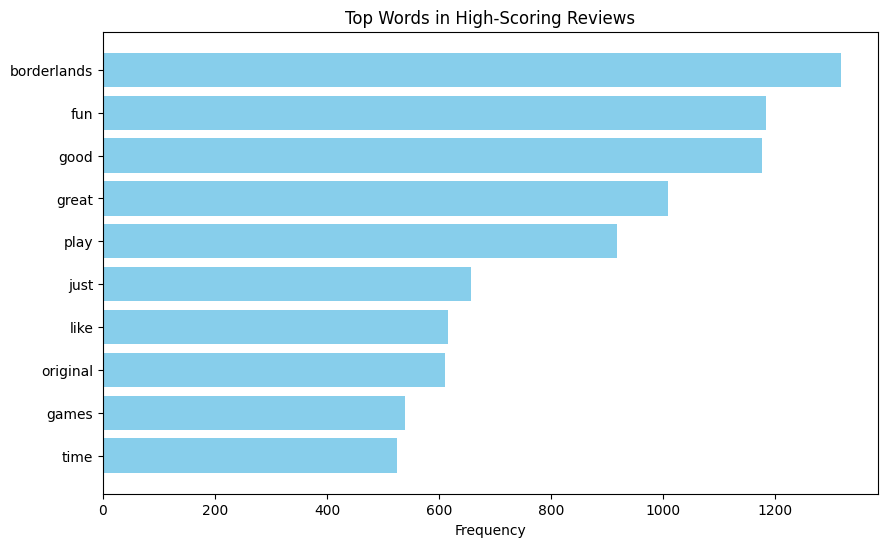

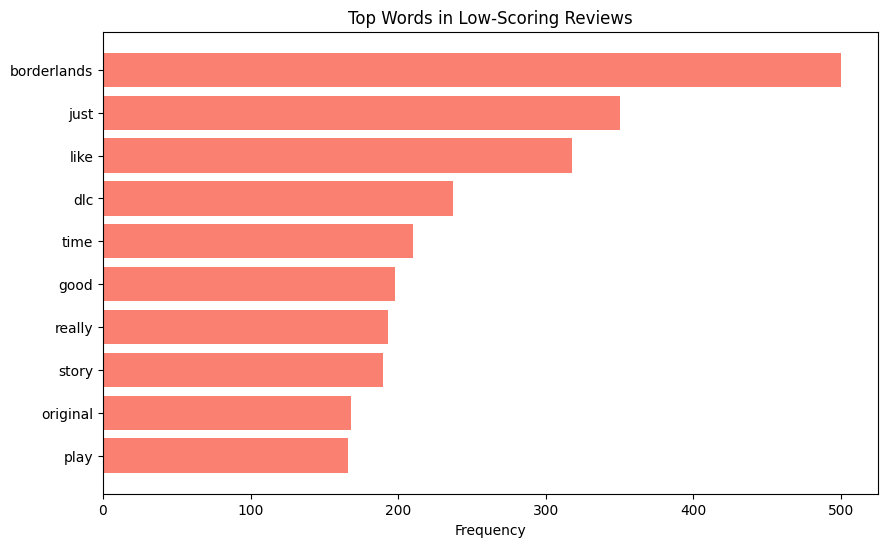

Reading with reviews-comp/reviews_1546970.csv


,review,positive,neutral,negative
2,Its actually sooooo underrated maybe the graphics are little off but i think its pretty good,0.932758,0.051651,0.015590
4,I have the original and I was excited to try it.. I heard it was a small team making this. Wether or not it feels like a mobile phone version. Fortnite gta 3 At least they put it on sale for often and 10 bucks each game. Not much to complain about. Recommend the original w resolution mod instead.,0.839365,0.141449,0.019186
6,Its full of bugs but its the same old story.,0.007639,0.091381,0.900979
25,full of bugs and terrible graphics,0.003080,0.023600,0.973320
32,Good game.,0.894992,0.095311,0.009697
34,Yeah this really did not age well too many shitty quests also this remaster has a lot of visual bugs. Why would you have rain on an underground tunnel for example.,0.002885,0.032851,0.964264
38,An indescribable piece of garbage code created by mediocre freaks (I am very ashamed before God that I finally decided to try this horror),0.003879,0.026702,0.969419
45,Very good game had hours of fun just blowing up cars teasing the police,0.966320,0.026022,0.007659
54,The weakest game of the trilogy but still very fun! As I stated in my other reviews the whole trilogy is worth getting on sale.,0.931088,0.061308,0.007604
55,Not bad.,0.871942,0.111893,0.016165


,review,positive,neutral,negative
0,ไม่เคยเล่นGTAภาค3ตัวแรก เล่นแต่ภาคVice CityและSan Andreas พอตัวDefinitive Editionวางขายใกล้ครบ3ปี และลดราคาถึงครึ่งนึงรวม50% เลยสอยมาเล่นแบบไม่ลังเลซักนิด บอกเลยว่าโคตรสนุกทุกด้าน,0.045873,0.780471,0.173656
3,mid mid midmid,0.147157,0.733166,0.119677
7,rockstar games launcher,0.125177,0.769465,0.105358
12,iy s a very uniqe game,0.059635,0.758678,0.181686
14,---{ Graphics }--- ☐ You forget what reality is ☐ Beautiful ☐ Good ☑ Decent ☐ Bad ☐ Don‘t look too long at it ☐ MS-DOS ---{ Gameplay }--- ☐ Very good ☐ Good ☑ It's just gameplay ☐ Mehh ☐ Watch paint dry instead ☐ Just don't ---{ Audio }--- ☐ Eargasm ☐ Very good ☐ Good ☑ Not too bad ☐ Bad ☐ I'm now deaf ---{ Audience }--- ☐ Kids ☐ Teens ☑ Adults ☐ Grandma ---{ PC Requirements }--- ☐ Check if you can run paint ☐ Potato ☑ Decent ☐ Fast ☐ Rich boi ☐ Ask NASA if they have a spare computer ---{ Game Size }--- ☐ Floppy Disk ☐ Old Fashioned ☑ Workable ☐ Big ☐ Will eat 10% of your 1TB hard drive ☐ You will want an entire hard drive to hold it ☐ You will need to invest in a black hole to hold all the data ---{ Difficulty }--- ☐ Just press 'W' ☐ Easy ☑ Easy to learn / Hard to master ☐ Significant brain usage ☐ Difficult ☐ Dark Souls ---{ Grind }--- ☐ Nothing to grind ☐ Only if u care about leaderboards/ranks ☑ Isn't necessary to progress ☐ Average grind level ☐ Too much grind ☐ You'll need a second life for grinding ---{ Story }--- ☐ No Story ☐ Some lore ☑ Average ☐ Good ☐ Lovely ☐ It'll replace your life ---{ Game Time }--- ☐ Long enough for a cup of coffee ☐ Short ☑ Average ☐ Long ☐ To infinity and beyond ---{ Price }--- ☐ It's free! ☐ Worth the price ☑ If it's on sale ☐ If u have some spare money left ☐ Not recommended ☐ You could also just burn your money ---{ Bugs }--- ☐ Never heard of ☐ Minor bugs ☑ Can get annoying ☐ ARK: Survival Evolved ☐ The game itself is a big terrarium for bugs ---{ ? / 10 }--- ☐ 1 ☐ 2 ☐ 3 ☐ 4 ☐ 5 ☑ 6 ☐ 7 ☐ 8 ☐ 9 ☐ 10 ---{ Author }--- ☑ https://vojtastruhar.github.io/steam-review-template,0.000000,0.000000,0.000000
43,it id db bddddj nd jn djndjlddsn vjdvnsdvnldsvnl l lnssdmnldsknl sjlns d xln slns mnl csdlnsdlkncadml cx l lnslnmzcxkl ndsklklmklzxmzxlckxz zlckzlznzlcnc xkzxmklzx zxklczclzxmklzxmk msdkmzxkm kdmk mlkzx zxzxzmklzcmzxclc mzxlm zxjc nxjc njlnxc jlxc zlncxnlxc zjnxc jnxc zln xclnzclnzcx zcx zxc,0.052197,0.849555,0.098248
44,gta3 innit,0.126384,0.747182,0.126434
73,i poped someone is the roaches nans wig,0.051930,0.801973,0.146097
118,You know if u pay close attention he kinda runs like a character from Super mario bros.,0.098617,0.824578,0.076806
131,𝙄 𝙠𝙣𝙤𝙬 𝙖 𝙥𝙡𝙖𝙘𝙚 𝙤𝙣 𝙩𝙝𝙚 𝙚𝙙𝙜𝙚 𝙤𝙛 𝙩𝙝𝙚 𝙧𝙚𝙙 𝙡𝙞𝙜𝙝𝙩 𝙙𝙞𝙨𝙩𝙧𝙞𝙘𝙩 𝙬𝙝𝙚𝙧𝙚 𝙬𝙚 𝙘𝙖𝙣 𝙡𝙖𝙮 𝙡𝙤𝙬 𝙗𝙪𝙩 𝙢𝙮 𝙝𝙖𝙣𝙙𝙨 𝙖𝙧𝙚 𝙖𝙡𝙡 𝙢𝙚𝙨𝙨𝙚𝙙 𝙪𝙥 𝙨𝙤 𝙮𝙤𝙪 𝙗𝙚𝙩𝙩𝙚𝙧 𝙙𝙧𝙞𝙫𝙚 𝙗𝙧𝙤𝙩𝙝𝙚𝙧.,0.071536,0.850308,0.078157


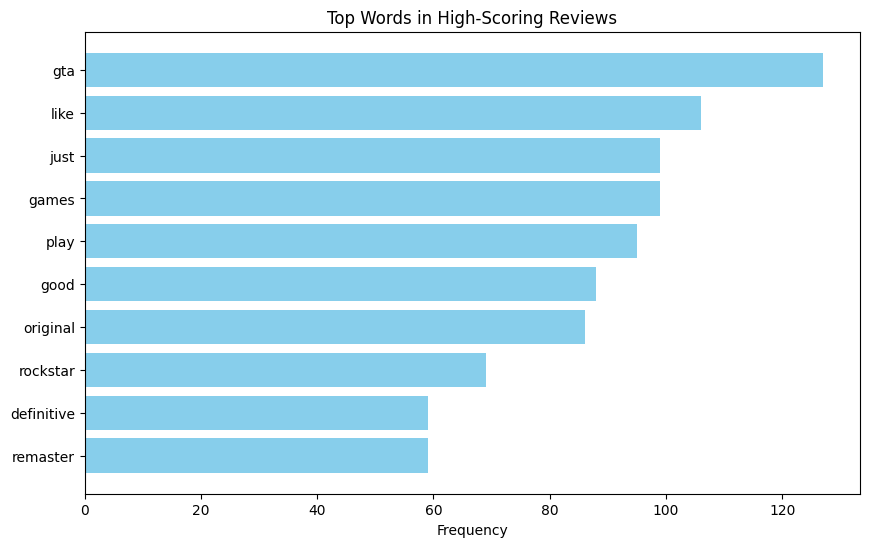

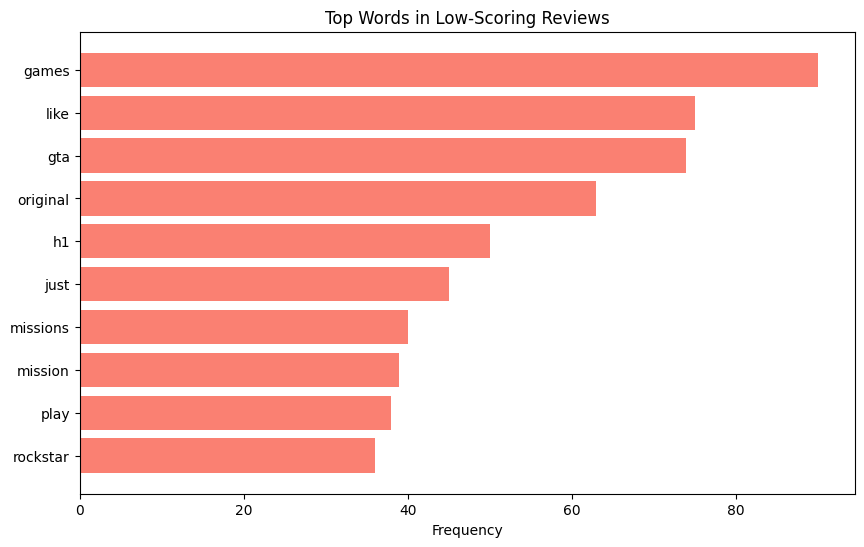

Reading with reviews-comp/reviews_1649240.csv


,review,positive,neutral,negative
0,A rare masterpiece! Seriously games of this calibre are very rare in this day and age. Its a real loveletter to gamers! Nuanced visually stunning innovative perfectly balanced utterly creative and nested in a gorgeous soundscape. Best played with 3D headphones DualSense controller and 21:9 monitor. Housemarque keeps on giving!,0.980002,0.018044,0.001955
2,I really liked this game even though it STRUGGLED to run on my computer. I would probably like it more if I played it at 60fps. Anyways story is abstract at times I tried to pay attention but gave up after a while. The bosses are really fun though some of them are shockingly easy at times. Example the final boss gave me no issues what so ever compared to minibosses or certain enemies. I enjoyed it. Excited to see what Housemarque does next!,0.983754,0.011696,0.004550
4,This is probably the most underrated game ever how this did not win game of the year back in 2021 or receive any awards is hard to believe.... the gameplay and character movement is so smooth and the combat is so satisfying... Only other game that gave me this kind of experience is Doom 2016 and Doom Eternal... Graphics are good with a really great particle system. The narrative and story while seeming confused at first is actually executed brilliantly and makes a lot of sense once you get to the end of the game... This game gave me an experience that I will not forget for a very long time and nowadays there are very few games that do this for me. The PC port does have some small issues here and there like stuttering at times but there are mods to fix that and overall I had a good experience. Co-op feature is really good especially at the beginning when the game may feel very difficult but it can be hard to find people as many do not play on pc... Overall I would recommend this game if you like rougelite shooters and want a different and unique experience compared to most games out there.,0.918079,0.065799,0.016122
7,Great quality if you have the specs for it,0.872779,0.117106,0.010115
8,I strongly recommend this game (if you like a challenging game...),0.974760,0.023612,0.001628
11,graphics are amazing and game play is legit. Not the type I game I thought it was but glad I bought it. Would buy again for sure.,0.976260,0.019882,0.003858
12,Incredible Original and interesting game. The gameplay is good the biomes are neat. I especially loved the Derelict Citadel which looked very inspired by the works of Zdzisław Beksiński,0.989400,0.009306,0.001293
13,Beat Act 2 and since then have had non-stop crashing to the point my SSD ends up being shutdown and Windows 10 cannot recognize it. I have to restart after every crash. Sony if you are going to put your games on PC then ACTUALLY code them for PC.,0.018594,0.136898,0.844508
15,Addictive arcade game play very progressive and stylish. rogue-like perfection. excellent game!,0.978357,0.019928,0.001715
16,[h1]One of the Best Rouguelites with AAA Quality[/h1],0.867436,0.130348,0.002216


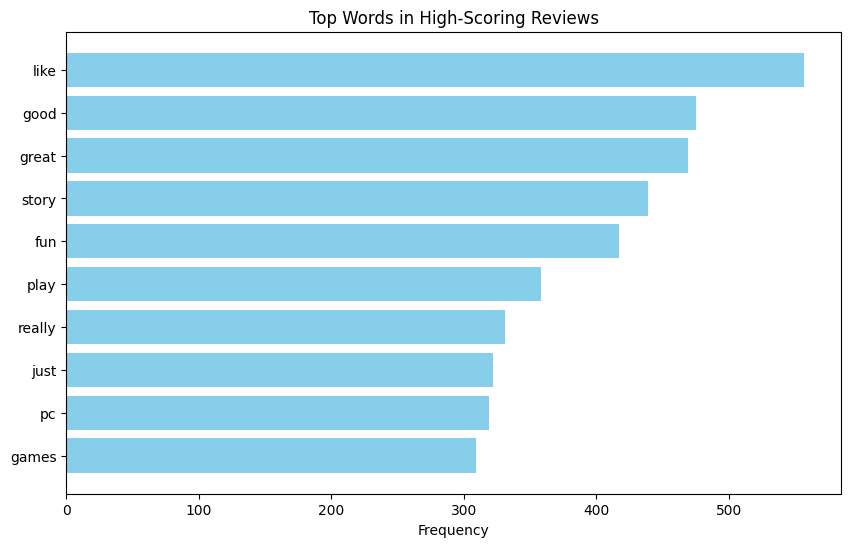

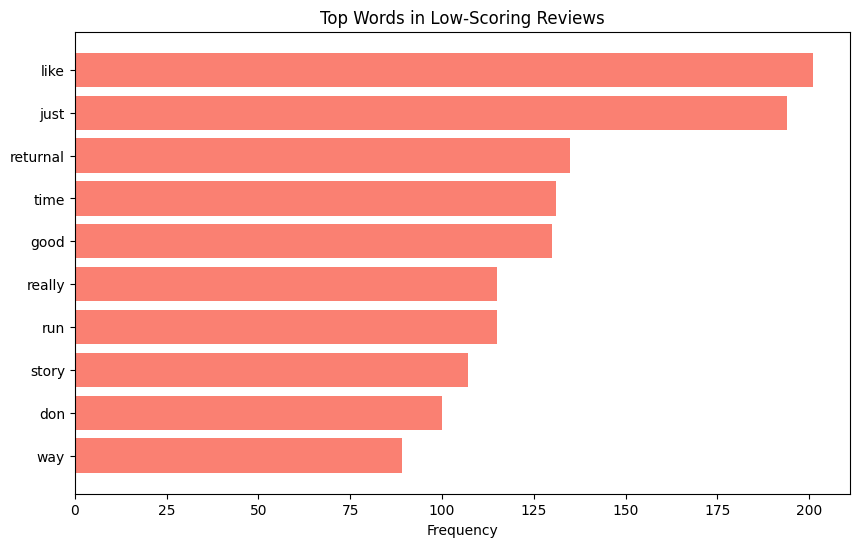

Reading with reviews-comp/reviews_8870.csv


,review,positive,neutral,negative
0,While it's not remotely the same game that was shown during previews and gameplay trailers back in 2011 don't let that hold you back from playing this amazing piece of art. The story art-direction writing characters and gameplay-loop still holdup 11 years on from release cementing it as one of the best FPS-games ever made.,0.933523,0.058408,0.008068
1,this has to be the best Bioshock game i have ever played the game play was good the enemies where fun to fight every single one the gun play was fun i never felt board or wanted to stop playing i would recommend this game the city setting and detail was amazing one of the best steampunk game i played 10/10,0.990566,0.006866,0.002568
2,Reactivated this game after a couple of years. Unfortunately they updated their terms of service to use primarily for data mining as it seems and as I won't agree to this I can't play this game again.,0.003462,0.046055,0.950483
4,One of my favorite games of all time easily a top 5 I have no words to describe how much I like this game. It is very different from the previous two installments but the final connection that they have and that we will discover throughout the game completes the trilogy in a masterful way. The gameplay is incredible the visuals are gorgeous and as I said I find the story fascinating. I couldn't recommend it more. It is a masterpiece.,0.991804,0.005999,0.002197
5,so good,0.962981,0.031365,0.005654
7,"On the grounds that 2K has recently added an additional launcher to the game while forcing you into agreeing to forced arbitration and a class action waiver NO ONE should buy this game or any other 2K game until they remove that. YOUR RIGHTS MATTER! DO NOT SETTLE FOR CORPORATIONS STEALING THOSE RIGHTS FROM YOU! It doesn't matter whether there is or isn't a reason for that clause to be present IT SHOULD NOT EXIST TO BEGIN WITH! Additionally this was NOT a thing when I purchased the game back when it released! This is a recent addition meaning they changed the terms AFTER the sale! I should be given full rights to get a FULL refund no matter how long I've had the game because they did such things to the terms. Scummy company. I declined your garbage and found a way around it. I refuse to accept it and I hope you go bankrupt for adding it. When in the game I then found that they also added a 2K account linking but because I never connected my Steam account to 2K's trash it didn't try forcing me to. I haven't purchased a single Ubisoft game since their failure of ""Watch_Dogs"" largely because they require some additional launcher and account and I can gladly do the same thing with 2K if they start doing the same thing. If I'm already connected to Steam STOP MAKING ME USE ANOTHER LAUNCHER AND ACCOUNT! And again STOP TRYING TO STEAL PEOPLE'S RIGHTS! Any company that tries to force people into any of this trash deserves to have their games pirated.",0.011238,0.111879,0.876883
8,Let me be clear racism has no function in todays society nor does it have any merit and this game is FULL of racism even at parody level this is still nazi germany tier hatefulness from the diverse team at 2K and its unacceptable.,0.002222,0.034709,0.963069
12,Interesting visuals. Boring level design. A lack of any boss design. Systems that don't matter as you are railroaded into combating the boss design/ clown closest combat. A race bating story that does has nothing to actually say once it writes its self in a corner. All of which is just a bad game laid over a walking simulator. This game relies upon the first sequence of the game being a revelation of racial discrimination and the end of the game ridding on the original Bioshock's coat tails. Despite getting the edition of the game that included the DLC it was not worth revisiting. Disappointing would be accurate if the game writers didn't go so far to introduce racially charged C4. Then when the writers had no where to go with there story running over with seething hatr

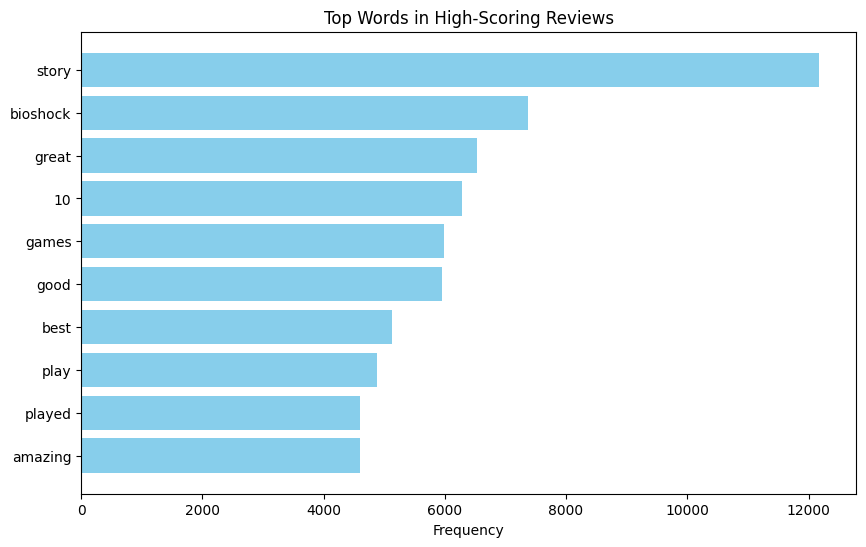

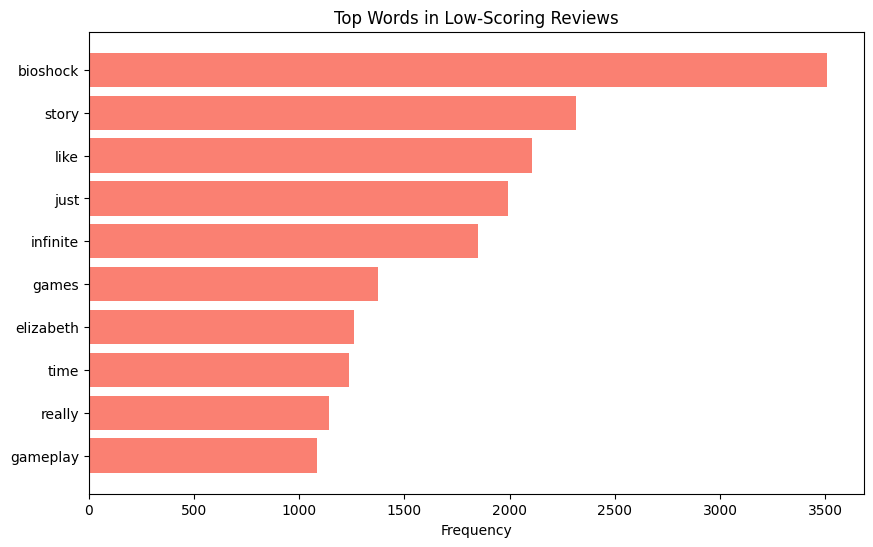

Reading with reviews-comp/reviews_261640.csv


,review,positive,neutral,negative
1,Well yeah obviusly this game has it's downsides but still AWESOME!!,0.895723,0.083465,0.020812
2,Awesome and addictive fun. A must play.,0.979524,0.017323,0.003153
7,good game,0.926890,0.064623,0.008486
8,much better than i remember,0.861841,0.122098,0.016061
13,Great side story from the borderlands universe focusing on jacks past with it being on the moon there are a few new and unique mechanics and a new set of vault hunters its a very good entry in the series but lacks anything to do at the end of the game due to a lack of activity and loot variety.,0.895118,0.082278,0.022604
14,is nice,0.843677,0.140512,0.015811
21,very underrated title overshadowed by the other games but it holds up a decade after release. Every borderlands game imo has truly stood the test of time. They don't feel stale or boring and I've been playing since 2 came out.,0.877410,0.110481,0.012109
22,this is my favorite borderlands game even though none of my friends like it. good story line great characters and i love to butt slam. 10/10 will play forever.,0.983879,0.011889,0.004232
23,pretty cool game bit overshadowed,0.836135,0.131514,0.032351
24,At first it seems like its a watered down borderlands game. But after learning more about Australian Culture this game becomes absolutely hilarious. 100% better than Borderland 3.,0.889683,0.086268,0.024049


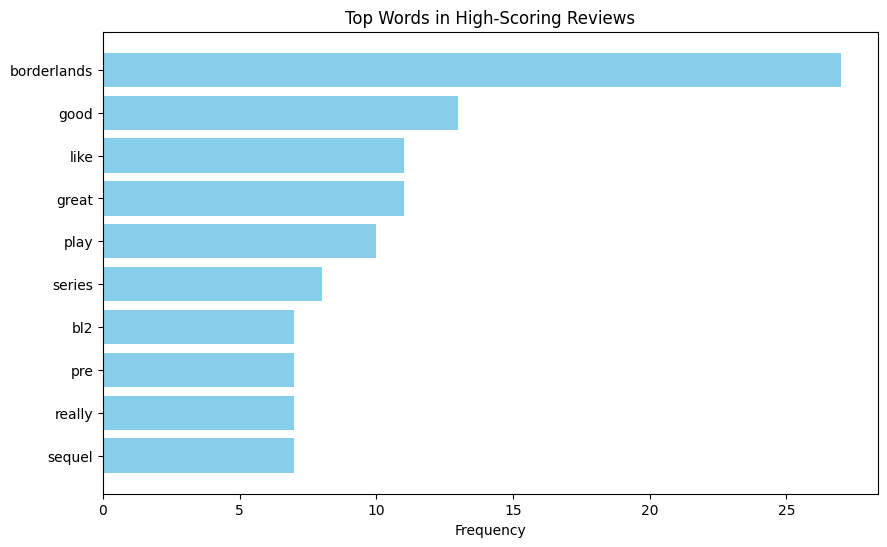

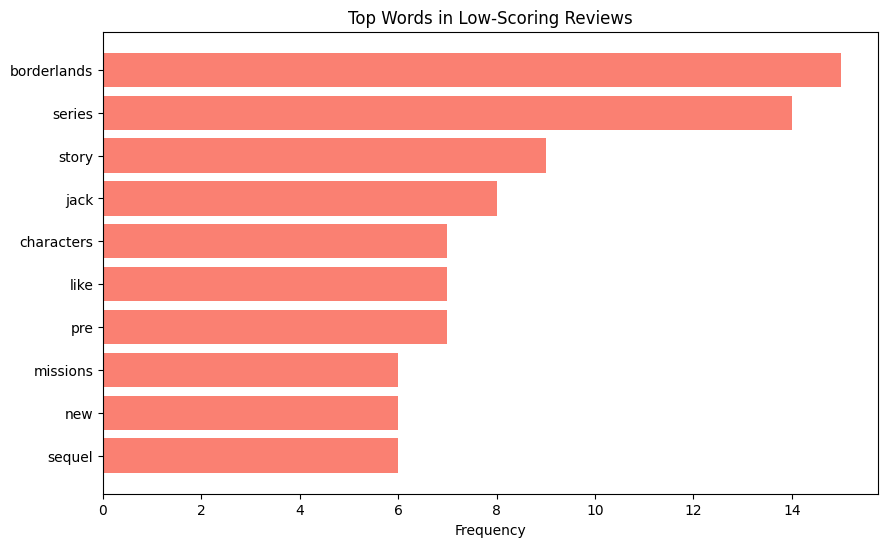

Reading with reviews-comp/reviews_1151640.csv


,review,positive,neutral,negative
1,Nothing like a great adventure game,0.913548,0.067108,0.019344
3,Love this game.,0.982442,0.013568,0.003990
4,awesome game hreat open world,0.972632,0.024480,0.002888
5,One of the best games of all times. you can do sooo much!,0.991564,0.006974,0.001462
6,Very good,0.951874,0.042852,0.005274
7,This is one of the big ones an amazing game. Great dialogue great story inventive and beautiful. Especially if you like single player adventure role playing games!,0.989427,0.009068,0.001505
9,Great game,0.936125,0.056957,0.006918
12,"I'm a ""mature"" gamer of 33 and this is one of my favorite game of all time in the holy Trinity sitting next to Halo and Skyrim. I'd actually have even more total hours played since I pirated this game at first. I liked it so much that I immediately rushed to buy it on Steam it is that good. Loose yourself into this world and your gaming life will change for good.",0.986811,0.011219,0.001971
14,doesnt support toggle aim cant get it refunded shit movement remaster needs PSN account dogshit company clown steam support,0.003427,0.040028,0.956545
15,Very intuitive to play. Engaging story.,0.885603,0.110682,0.003715


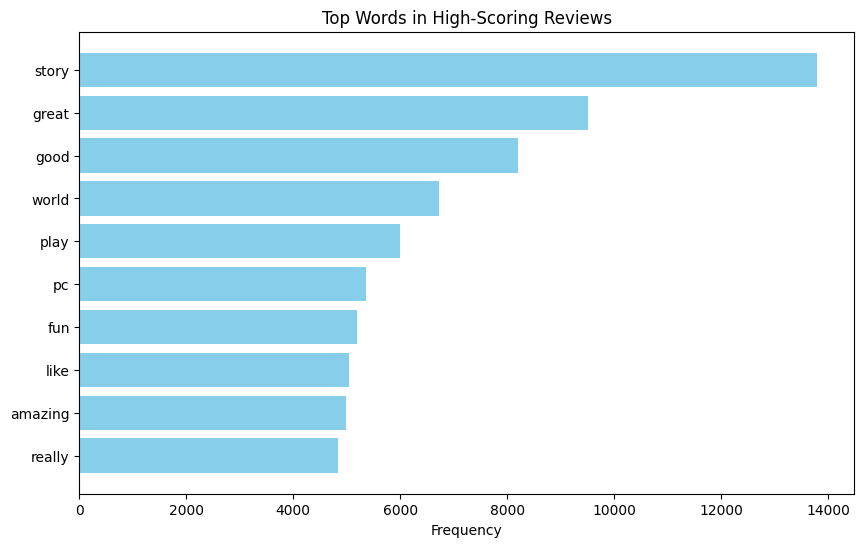

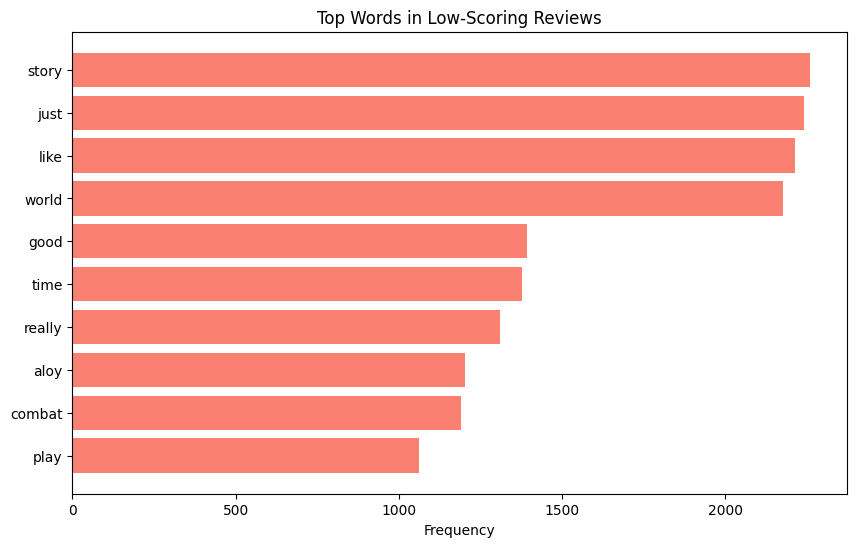

Reading with reviews-comp/reviews_1599660.csv


,review,positive,neutral,negative
1,Sackboy is such a fun game alone and with friends just as much as it was on the Playstation. Its wonderful that it allows you to open to multiplayer so you can complete team levels with someone. It has some challenge and the puzzles are fresh and intriguing. The musical levels are always so much fun the way they are designed to match the song. 10/10 would recommend.,0.990693,0.007389,0.001918
2,I play this game with my sister. It really takes me back to when I was young and played this on the PlayStation thank you for bringing my youth back!,0.970186,0.028174,0.001640
3,This game is so fun. I would recommend this to all newbies out there gives you a chance to get accustomed to using any gaming controller Of your choice. I have tried switch controller and p.s 5 controller. I enjoy the p.s 5 the newer one its awesome. I'm also getting better at playing very enjoyable. Easy for children 6 and on and the child within adult's cant stop playing this game,0.990209,0.008018,0.001773
5,Best soundtrack ever and great co-op!,0.987017,0.011254,0.001729
6,probably the best platformer game i have ever had the joy of playing in my entire life,0.988495,0.009438,0.002068
7,Love playing Little Big Planet and all their sequels.,0.978938,0.018778,0.002284
8,Very nice game and easy to play as good as IT TAKES TWO and even better (especially the music haha,0.989267,0.009330,0.001403
9,Lots of stuff to collect. And its adorable.,0.974238,0.023666,0.002097
18,This game will make you miserable in every way possible. this game is my biggest enemy.,0.003655,0.023611,0.972734
20,amazing game to play with your partner or a friend. Been a fan of Little big planet series from a very long time and this game didn't disappoint. Amazing!,0.990568,0.007997,0.001435


,review,positive,neutral,negative
19,ballsack adventures,0.109420,0.719744,0.170836
45,little big planet go hard,0.180883,0.703524,0.115592
64,[list][*]ㅤI have always liked the Sony brand. Sony's games are like members of a family often featuring crossovers from different games and [i]Sackboy: A Big Adventure[/i] delivers this in a proper manner. [*]ㅤThe game is a 3D platformer in the style of [i]Rayman Legends[/i] or other games of this genre but more up-to-date in terms of gameplay graphics mechanics etc. It is somewhat easier in difficulty than the aforementioned game but it can be challenging at times (getting gold in the time trials especially the last trial; those who have played this game already know what I'm referring to). [*]ㅤThe porting of the game from console is good with no bugs or anything significant that would affect your enjoyment of the game; I did not encounter any problems related to movement / combat. The controls are smooth with a fast output response. [*]ㅤThe level design is fascinating with an impeccable attention to detail. The gameplay is fun (though it becomes repetitive over time) with specific music for each level some even being well-known hits from famous artists. If you're an achievement hunter you'll have a hard time getting all the achievements in this game as some of them require a second person to play with. The game seems to have a pretty low player base at this time because the servers feel dead and matchmaking is almost nonexistent; so you'd better grab a friend to play with. [*]ㅤThe story didn't really impress me considering it is simple and minimalist. The game's ending without giving away too many spoilers leaves much to be desired. It's not a total fail when we look at the story throughout the game but neither is it the most extraordinary ending that you'll remember after some time; rather it’s a vague uninspired conclusion that happens abruptly. [*]ㅤWhat did I learn from this game? That in life you often need to have patience to overcome certain obstacles (again those who have already played or will play this game will understand what I’m referring to).[/list] [quote=Game Overviews][i][url=https://steamcommunity.com/groups/GameOverviewsUS]Game Overviews group[/url] [url=https://store.steampowered.com/curator/45195325-Game-Overviews/]Game Overviews' curator page[/url][/i][/quote],0.000000,0.000000,0.000000
111,LITTLEBIGPLANET,0.132653,0.764180,0.103167
113,skbiidi otielt its ttrel,0.077874,0.740482,0.181644
223,can I eat the stuffing?,0.026019,0.786855,0.187126
245,My Review:,0.065612,0.803095,0.131293
271,Worth the 60 bucks.,0.196079,0.765418,0.038502
289,I lob et,0.147600,0.655739,0.196661
377,is sackboy breedible?,0.036303,0.765182,0.198515


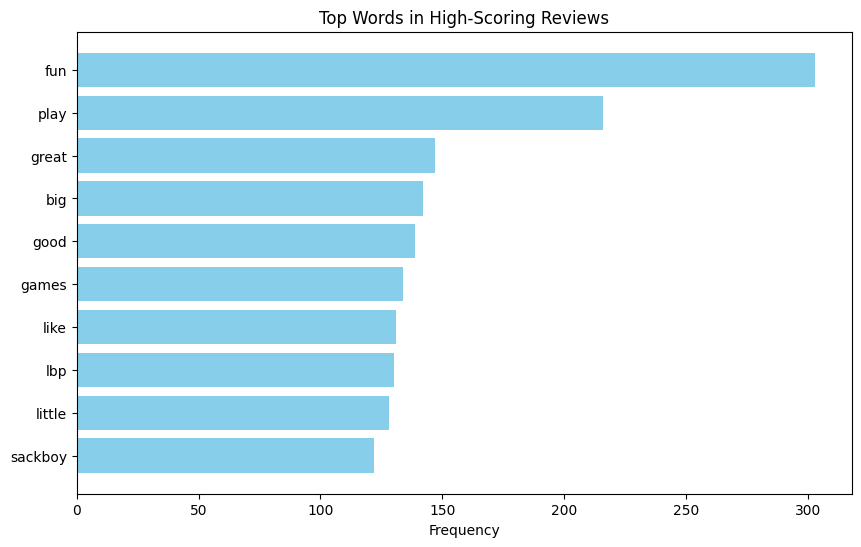

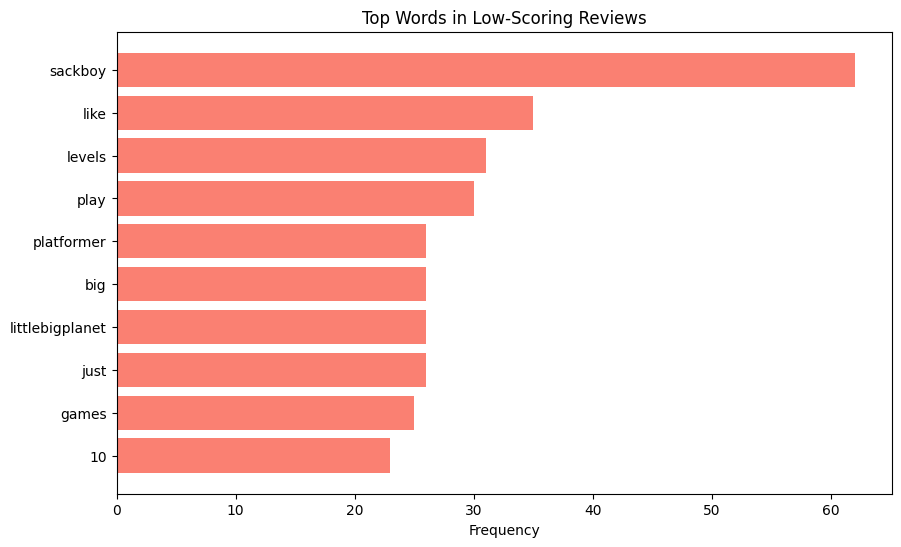

Reading with reviews-comp/reviews_1895880.csv


,review,positive,neutral,negative
0,An absolute blast of a game!,0.958838,0.034049,0.007113
4,Great game easy to 100% too which is appreciated. PSN not required at the time of review.,0.960386,0.035518,0.004096
5,Stop.. you're scaring me...,0.007280,0.095585,0.897135
9,Not much enemy variety but still very fun and pretty,0.961609,0.033196,0.005195
11,I bought this initially as I missed the old days of playing Ratchet and Clank on the PS2. This did an excellent job and bringing back that enjoyable time of playing games. Not super in depth though great story line and fun characters with enough customization to keep you into the game.,0.960573,0.032882,0.006546
12,This game is extremely worth purchasing but keep in mind you need a m.2 ssd that has 3.5gb of speed but if you have the requirement do yourself a favor and get this game its like a roller coaster.,0.917111,0.077449,0.005439
14,great game great visuals but gimme more rivet and kit next game. their parts just felt more fun overall and rivet is just plain more badass than ratchet and kit would be more fun than clank,0.951641,0.042747,0.005612
15,They hit it out of the park once again with this one I would love it if they brought the previous Ratchet and Clank releases to PC,0.964432,0.032547,0.003021
18,Have been playing and enjoying this franchise my entire life. Another great addition in beautiful graphics.,0.988234,0.009868,0.001898
20,Amazing game that took me right back to my childhood!,0.984285,0.014198,0.001517


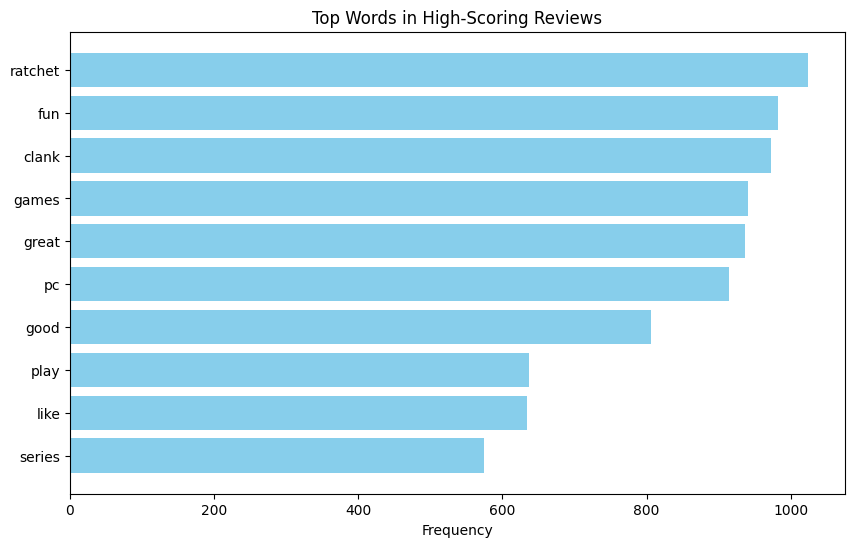

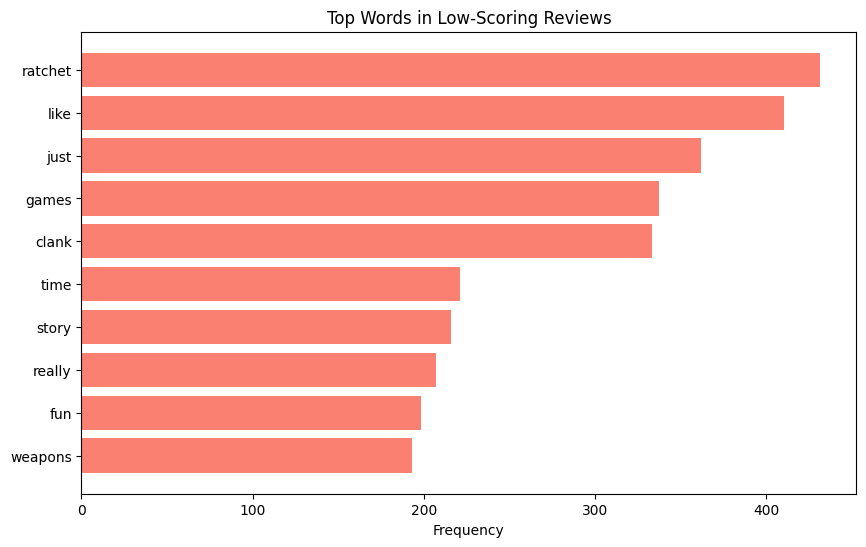

Reading with reviews-comp/reviews_397540.csv


,review,positive,neutral,negative
0,While the story itself may be a little lackluster compared to previous installments this one gets a thumbs up for the excellent gun play the best of the series by far.,0.904499,0.084290,0.011211
1,Game is unplayable on PC since the jump button does not function.,0.002557,0.033794,0.963649
3,always fun,0.924372,0.068114,0.007514
4,great gameplay coop is lovely,0.985512,0.011928,0.002560
7,Enjoyed BL2 didn't like this at first. Came back to it this year and really enjoying it. Looking forward to the fourth one despite the movie being lame.,0.894740,0.078717,0.026543
10,I absolutely love all of the Borderlands games! I've played very single one except Tiny Tina's spin off game and I am going to try that one next. Love the depth of these games!,0.992283,0.005738,0.001978
13,fun on the epic game store fun on steam,0.963015,0.035380,0.001605
15,This game ruined my life,0.003726,0.020341,0.975933
16,Very fun game. I co-op with my wife. Great shoot and looter.,0.985843,0.012179,0.001978
17,fun good gameplay just pure fun,0.938282,0.055900,0.005818


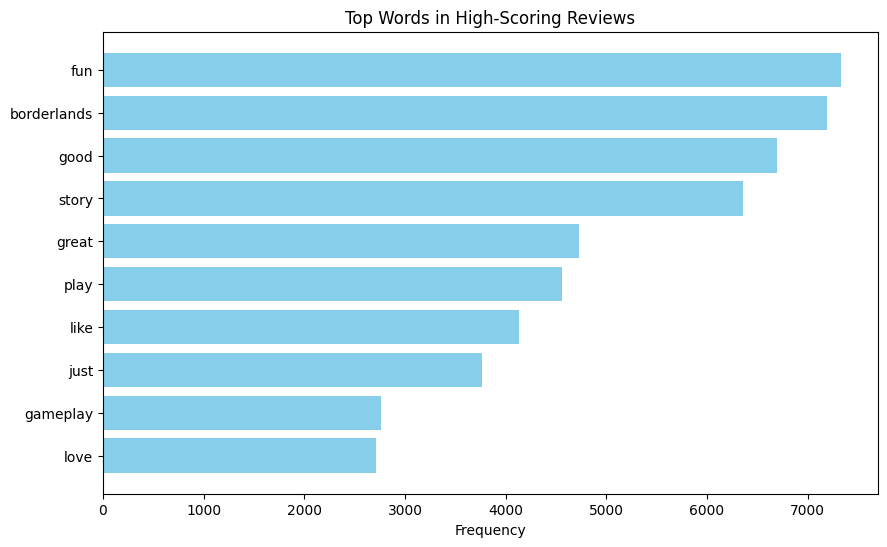

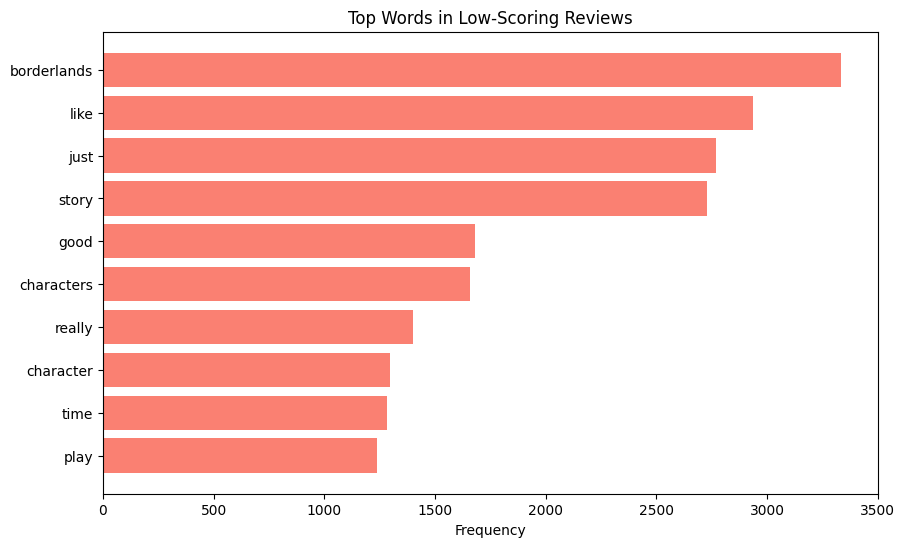

Reading with reviews-comp/reviews_1547000.csv


,review,positive,neutral,negative
3,Crashes way too much. Stupid URE4 Fatal Error bull...,0.003659,0.027283,0.969058
4,flying and controls ar worse,0.004887,0.088967,0.906146
10,Pure nostalgia this GTA was so ahead if its time had so much to do with 3 cities and many activities along side the great story was my favourite of the franchise when i was younger and remains my favourite till this day! now i have done the 100% i am going back to play around with the cheats as its what i spent 90% of my time doing when i was a kid :D,0.958188,0.037619,0.004193
11,this game has so many bugs its just so insane i cant believe it,0.003755,0.019435,0.976810
12,Buggy. Flight controls suck.,0.005042,0.034837,0.960121
13,This runs great on the Steam Deck and my PC I've been enjoying this nostalgia trip the game still looks good!,0.990961,0.007619,0.001420
15,Useless motherfucking devs from grove street games they deserve to be binned. These devs deserve to have a special black-list and never be given a job in the future.,0.002329,0.018315,0.979355
16,ah shit here we go again,0.008619,0.088895,0.902487
17,It is a really fun game and in my opinion it is better than the original GTA San Andreas since it has way better graphics it is just a beautiful game and I recommend it.,0.988150,0.009898,0.001952
20,I love everything about this game,0.987920,0.007924,0.004156


,review,positive,neutral,negative
6,like old times...nostagla,0.156483,0.771397,0.072120
7,Grove street home...,0.119641,0.808585,0.071775
8,Childhood definitive edition,0.061290,0.839171,0.099539
25,Ill have 2 number 9s a number 9 large a number 6 with extra dip,0.065003,0.924225,0.010772
31,Humanizaram muito o jogo com esse remaster ficou melhor que o original,0.056355,0.869206,0.074439
116,Find a way to play the original,0.095909,0.832589,0.071502
126,Ну ПрикольнаяЖаль что я сделал возврат,0.051156,0.789300,0.159543
144,big smoke,0.151161,0.649084,0.199755
149,https://www.youtube.com/watch?v=wdfLr97nblE,0.052456,0.789251,0.158293
152,Compralo de rebaja sino no vale la pena.,0.075740,0.731449,0.192810


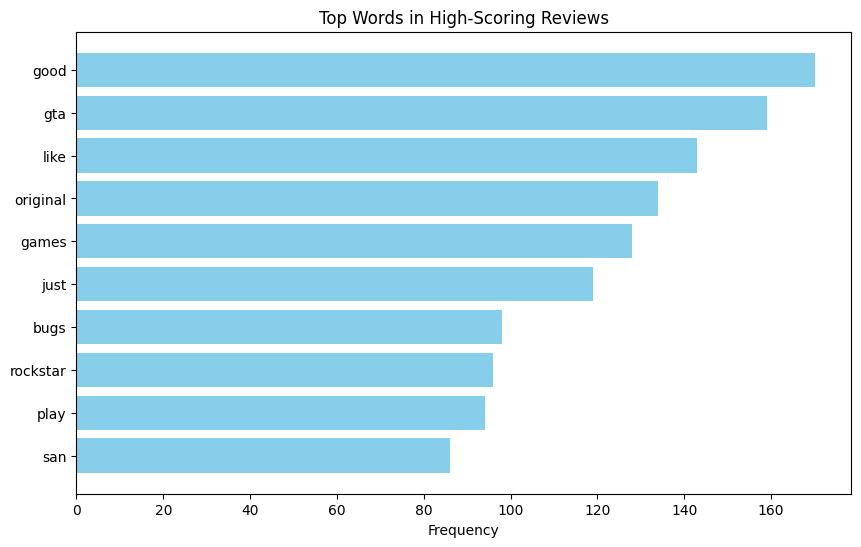

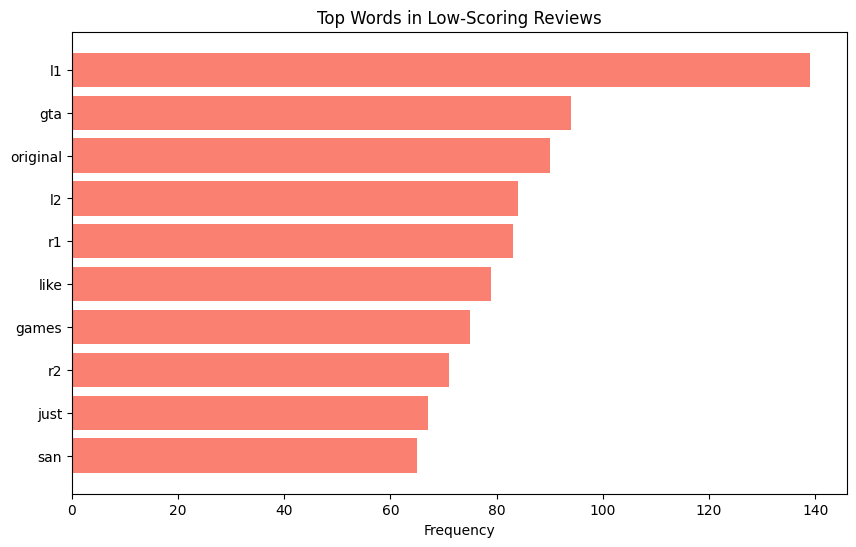

Reading with reviews-comp/reviews_2668510.csv


,review,positive,neutral,negative
0,Well I already beat this game twice (first time around 2010-11 on the Xbox 360 and second time last year 2023 on Switch) soon to be thrice now as I just started the Steam version. So I can say I'm qualified to review this even though this is my first time playing it on PC. First off I'll say the PC version looks phenomenally better than the 360 and Switch versions like everything except the characters skins looks almost like current gen tech lol. Its extremely good looking. Idk if this game even needs and introduction its Red Dead and a rockstar game so you'll know its a banger. But I will say the story is definitely enhanced after having played RDR2 since RDR2 is a prequel. I will say though the Undead Nightmare dlc is extremely interesting and it's a shame they have never done anything similar since. So well I recommend it bought it three times after all lol.,0.968806,0.027033,0.004161
3,amazing game,0.901452,0.088366,0.010182
4,Game runs great on PC and Steamdeck. Classic game and a must play for fans of RDRII. However very overpriced for a game that is over 10 years old,0.907054,0.078274,0.014671
5,a really good move after 14 years... oh did i mention that it is optimized for modern hardware as well,0.965255,0.032034,0.002711
6,An amazing port of one of the best games of all time AND one of best standalone DLC of all time. It runs smoothly and looks great while maintaining the heart and soul of the original game from the ps3/360 era. This is how ports should be done. Nothing else needs to be said.,0.983264,0.014385,0.002351
11,Classic game that runs smooth and looks great in 8K Ultrawide.,0.975983,0.022616,0.001401
14,One of Rockstar's absolute masterpieces finally brought to PC. To me this game is better than Red Dead Redemption 2 due to this game having a more arcade and faster gameplay compared to RDR2's slower gameplay and the strong spaghetti western feeling this first game has. Everything about this game is really well done. Writing characters ambience music gameplay open world everything. It's a Rockstar game you don't even need to read any of these it's common sense. The Mexico part of the campaign can start to drag on a bit too much but that's pretty much my only complaint. The Undead Nightmare expansion is also included and it's probably one of the best expansions ever created for any game.,0.925675,0.062626,0.011698
15,Finally an amazing PC port of the greatest game ever made,0.984570,0.013645,0.001785
16,10/10 cant wait for red dead 3: Into the Dutchverse,0.980982,0.017246,0.001773
17,you need to sign in to an online launcher to play which already stupid but also the game is literally unplayable. It has no macOS port so you need a 3rd party program to play it and you get a fatal crash just trying to launch the game. Rockstar please fix this,0.004493,0.033749,0.961759


,review,positive,neutral,negative
7,Ą̴̴̶̡̨̡̘̘̫̯̬̥̲̳̜̯̤͈̦͎͖͉̮̼̭͓̠͕̪͚͔̥͛́̄ͧ̇̓̉͗̌͂̍͐̈̓̈ͬ̂ͥ̃̏̑̿̌̇̈́̓̑͑̿̐̕͜͜͝͠ͅs̴̢͇̲͕̄͑͒ͧ̀̽̀̈́ͩ̌ͫ̉́͛̂͘͢͞͠ͅ_̦̒ͩ͛͢h̸̷̵̵̡̛̙̰̤͓͔̻̘̫̼̦͍͈̱͖̘ͮ̄͗̽͛ͨͤͫ̌͋̃̈̉̈́ͯ̐̀̀͌ͬ͊͗͛͛̓͌́͋ͧ̌ͯ͂͑ͣ͌ͥ̏̕̚̚͢͜͟ͅ ̸_ͨͩͮͥṉ̵̵̡̻̝̘͕͍̼͈͖͓̗̙̘̇̈́̂̎̎̌͐̊̔ͮ́͐ͬ̏ͦ̀͌ͬ̕̚a̡̩ͯ̂_̶̴̶̡̨̡̛͔̺͓͇̼̩͙̯̰̫̪͇̼͂̂̊͛̿́̇̍̉͑̽͊̇̄́ͣ̍̀̂̇ͣ̕̕͟͝z̒̾_̶̸̴̵̢̡̺̦̺̖̥̖̼̥͙͈͍̲̠ͥ̀̓͊̽ͫ̃̓ͧ̂͑͌̂̑͒̊̄ͫ̿̃͊̉͞ĝ̷̛̛̛͔̬̻͙̤̙̰͉̞̘̭ͫ̃ͯ̀̈́ͯͩͨ̐ͬ͋ͨ́ͦ̈́̒̇̋̽͛ͥ̋͂̚͜͠_̸̢͈͇̠̲̻̟͈̠̥ͭ́̒ ̵̢̟͓̣̯͓͖̫̋̃́͗̐͗̿́ͫͧ̕̕ͅd̷̷̸̷̷̷̪̱̣͚͙͉̙̜̬̤͋̀͋̉ͫͧ͗͊̌͗̃̃̐̌͋ͨ̇ͦ̔̄͒̆ͦ̚͘͜͞͡͝͠͡ü̴̯̳ŗ̵̵̴̠̞͓͙̟̙̙͖̞̗̼̯̦̍̾̄ͧͭ̑̿ͨ͗́͊̚͜b̴̸̴̶̧̛̬̲̺̮̣͙̯̜̘̖̜ͭ̍ͮ͛ͨ͒̔̇͛ͩ̿͋̀͛̇ͨ́̈̚͡a̵̵̧̛̺͚̦ͥ̑ͮ̂ͨ͒̽̽̇̑̓̄͋̏͜_̶̸̶̵̡̧̛͇̣̮̼̤̭̪̝̝ͣ̊͌ͥ̓̇ͫ̐͆͐̔̕͟͝͝t̶̴̸̶̡̢̯͔̹͖͇̩͈̻̲̝̜̬̱̩̻̠̗͈͍̞͙̱͉̅̿̀̌͗͆̌̑̈́̅̌͌ͤͣ̂͛ͥͦ́͊̎ͪͤ̽̀̅̾ͪ̓̄ͨ̓ͫ̆̀͒ͩͩ͛͘͢͟͝͡ͅư̸̧̯͉̜̯̮͉̐͗ͬ́͒ͤ̎͐̀̆̆ͦ͢͡ͅl̶̶̷̴̴̵̶̢̢̧̡̨̡̧̨̛̖͖̞̱̦̝̠̼͕̞̝͙̙̬͎̙̭̆́̑̐̋͌͐ͣͮ̒̈ͫ̐̓̑͋͗́͗̿ͨ̎͐̔͗ͧͭͫ͒͊̓ͬ̄̋̕̚͜͢͞͠͠͞û̴̴̶̧͎̘̲͇͎̳̯͕͙̭̞̱ͣ̃̐̂̓͐ͭ̄ͣ̎̌̒͋̐͋̅̕͜͡͡ķ̸̛̥̰̘̇͋̅̄ͯ́̈͞͡_̴̷̵̶̧̡͙͖͎̦̻͎͔͎̟̝̖̤͔̦̘̹͗̇͗̇̏ͨ͊̌͒́ͫ͌ͥ̄̐ͣ̏̓̆͆ͩ͛ͭ̈̚͜͢_̶̹̥̎̕ ̶̴̡̯̖̹̯̮̺̾̿͆́̽̔ͫͦ̒̚_̡̡̭̟̼̇̾ͮͪ̇̑̓ͫa̶̶̶̛͓̳͇͖̙͉̘͕͚̮̫͉̘̰͂͗ͨ̋̑̾͊̾̔͟͠s̶̸̙̥̰̺͇̩̮̥̬̮͉̠͚̬̤̻ͣ́͂̏́ͯ̽͌̀͂̈́̏ͣͨ̔̀ͮ̐̕̚͝͡͠ͅͅḩ̸̸͓͙̜̼̻͎͙̰̫͊̐̊͋͑ͭ̉͠_̷̠̟̙̠̩͔͍̮̳͊̃ͬ͑ͦ̓͠͞ ̷̶̡̖̮͍̦͉͔͌̈͋͌̇̿ͤͩ͆̕̚ň̵̵͓͈͉̞̪̟̤̩̮̐̇ͤ̃͊̒̍̏ͧͫͧ̿̿̚͘̚͟͢a̵̧̧̢̘̙̻͕͙͖̦̖̳̜̮̝̞̫̭̹̼͍̼̣̟͑̀͒̅̒̂̃ͨͯ̾̿̀̾ͥͨ͌̔ͣͩ̐͋̚͟͜͠ͅ_̷̷̢̯̥̺̰̩͎̳̟͍͖̀̿ͬͪͧz̷̴̴̢̧̰̩̣̣͔͉͔̰̱̖̩̞̠͇̫̹̭̗̼̱͙̰̹̣̰̫̤͙̝̦̋̉ͭ̿̋͐̔͐̍ͤ͒͊͗̇ͯ͆̄͊̍͋ͨ́ͣ̈͑́̐ͦ̈́̔̾͐͛̏ͨ̏ͤ͗̽̀́ͭ͊͐͒̚͘͟͠͝͡ͅͅg̴̴̥̯̮͍̣͓̲̎͌ͨͮ̄́͂͆̚͟_̧̢̛̮̞̼͚̮̘̦̰͗̈́̃ͭ̊̽ͯͪ̌̒̈́̂͂̆̋͢͞ͅ ̶̶̨̛͙̞̯͓͚̰̲̹̣̓͛̑͂̿̅̏́̏ͧ̇́͆͆̽͂̅͜͞͝͠_̷̵̢̼̠̰̬̿͛͑̉ͤg̸̵̷̷̝͔̯̼̗͎̮̭͎͇̩͇ͩͬ͑͐͛̈̿̔́̀̎ͯ̃ͧ̊̎̓͛̉͘͟͠i̸̷̷̸̵̶̵̡̢̢̮͈̙̥̻̹̝̰̯̺̭̗̻̻̲̗̰̻̹͓̬͗ͪ̇͗́̄͛͂ͥͣ͆̈́̏ͨͭͤ͛̆̐ͪ̿̆͊̇̈́̍̏̂͘̕͠͠m̶̶̶̷̡̡̧͎͉͖̣̥̹̳̻͎̙̳͖̆ͯͦͤͪͫ́͗̃ͫ͋́̆̀͌̈́̌̉͡͠͡ͅb̴̡̥̲̬͔̥͙̼̠̫̃ͬ̅̐̇̎a̶̸̡̧̨̡̛̘̮̮̩͙̳͍͉̱͍̻̣̹̭̹̺̞̻̬̤̪̻̝̠̣͖̤ͣͣͩ͗̀̍ͬͪͭͫͧ̀͑̃ͭ͋ͦͮͬ̋̔̈́ͩ̇ͮ̋͂ͪ̀ͨ͌̚͢͡͞ͅͅţ̷̴̴̴̢̠̗̺̖̙͖͕͓̰̼̬͇̰̰̮̗̓̏̾͐̂ͪͧ̇ͫ̿̅̒̔ͩͧͪͭͦ͐̽͊̕̕̕͢͜͜͡͡͞͡͠ͅų̸̷̷̧̩̗͇̥̭̗̰̖̼̳̩̫̦̠̯̳̠̱̜̙̻̟ͧ͂ͦ̓ͩ́͗ͤ͐̓ͫ͑͑͐̑̏̎̉ͥ̓͐̈́͊̏͘͢͜͜͜͞ͅl̷̵̶̡̧̗̜̘̟͖̺͎̜̺̗̪̮̮̻̻̪͇̲̥̟̥̗̯̺̰̖̪͗̓̀̈́ͩͧ͐͐ͣ̽͂͌ͧͭͣ̐̒̌̓ͧ͐̽̂͋̌̎ͯ͂ͮ̈́ͩ̎̓ͬ̚̚͟͟͜͝͝͠ͅ ̷͙̻̝̭̺͔̰̫̮̓͆ͦ̑̉ͥ͐͗̕͢͞͠a̓ͮ͛ͬͥ̚͜͟_̵̷̳̹̞̙̝͎͎̘̮͇̇ͪ̽̆̈́̆ͧͨ͂̾ͯ̂̅̕͘͢͟͝͠s̵̵̨̡̧̨̯̗̼̩̘̳͖̮̗̙͚͖ͬͦͤͫ̓̍̆̅ͨ̇ͨ͊ͣ̂̅̏ͣ̑̋͋ͯ͆ͥͦ͂ͤ̚͢_̶̧̖̬͎̮̙͚̻̼̤̖͇̘̃ͮ͆͛̇ͥ̑̓̔̽ͮ̍̏̄̏́̚͢͟͡ḩ̢̯̲̼̦͍̫͑͂̑̒̊͗̾̉̆͢_̷̭͇̦͙̠̞̫̝̳̹͔̘͎̳͚ͫ̒ͤͯͤ́ͯ͋̓̓ͣͪ͐͊̆̃̋ͬ͌ͩ̐̒̕͜͟͠ ̴̧̫͖̱̱ͤ̏̒̓̈́̀͂̓ͫ͡n̷̸̵̶̨̫̯͔̞͔̜̰̝̩̺̭ͫ̒̉͑ͨ̏̀̒̃̌̿͆ͤ͋̑͋͐̑́͘̕͘͢͡͠ͅͅa̹͈̰̥ͬͬͦ̓ͤ͋̀̐̉͜ͅ_̶̴̨̨̡̡̛̛͓͓͈͈̝̟̖̗̦͕͉̱͓͔̫͙̘͎̐̾͒ͩ̿ͫ̓̇ͯ̈̇̇̌̊́ͫͣ͘͢͠͝͠͡͠z̶̴̵̲̘͔̺̲̣̩̹̦͗̑͂̋͌̄̀̽͑͟͡͡_̷̛̝̈́ͤ̒ͥ͊g̸̨̧̛͈̱ͯ̽̇̊ ̶̪͍̥̘̏ͩ͌͜_̶̶̦̺͇̱̠̝͈̻͈͕̗͕̱̟̘̱̖̜ͭ̓̑ͯ͂̒̆ͪ̑̈̉̒́́͢͠t̵̷̵̴̡̛̳̲͖̼̜̣̪͖̙̙̣̭͔̙͍͙͚̥̫̺͖͐̇͛͊͋ͩͦ͛̂̋͑̓̽͛ͫ̃͒͋ͧ̏̎ͩͭ́ͦͮ̕̕̕͜͢͡͝h̴̸̴̢̡͕̣̦͇̱͙̝̖̠̗̳͖̬̤̝͕̹̝̭̱̠̞͎̻ͮ͐ͧͭ̍͑̾̈̓̽͊ͥ́͊̔̀̒̌͊́̌̍̔ͨ̃̾ͥ̈͒͜͟͟͢͞ͅr̶̷̴̶̢̧̧̺̳̻̜̰̺̮͔͍̥̹̲͉̠̖̝̹͎̤̪̔ͤ̀̄̓̈́̿̇ͣ̊̄̎ͣ͒ͦ͑͛́ͣ̉̇͗̊͊ͤ͂̔̆͊̐ͮͨͯ̔͘͢͡͠ā̸̸̵̢̢̧̨̢̨̗̩̭̪̙̻̘̲͍̜͔̻͇̣̹͙̮̞͇͈ͬ́́͂̏̌ͦͧ̐̀ͣ̃̅̇̆ͩ̒ͩ́̓͛ͪ͑̅̆͘͘̚̕͟͠͝͞͝ķ̸̢̩̭͖̥͚̟̯͔̙͔̮̤̲͓ͧ̓̅̑͗͊̈̿͆̃͒ͭͤ̓̒ͭ͐ͭͧ̓̚͟͜͞ắ̶̷͚̱̠̩͓̹̳͇͈̜͇̹͇̝͈͇͔̯͕̱͈̲̣̗͖̭͐̏̀̔ͧ̈́ͫ̈̃̉̀͒ͮͨͤͮ̔̀ͯ̅̾̎ͬ͐͐ͯ̈ͪ͟͡ţ̶̶̶̢̲̫̻͕̞̗̥̼̟͈̘̬͖̭̳̘̳̱ͭ̽̋̅ͥͤ̏ͩ̓́ͣ͊̎̂́͗͘͢͢͜͠͡u̵̶͍͎̖̭̮͇ͣͯ̿̌͒_̛̪̫̣ĺ̴̸̴̨̡̢̛̖̹͙͈̪̳̲̖̠̺͇̘̝͉͈̓̏̐̒͗̈́̔͑̈ͥͯͬ̽̐ͣ͆ͫ͟͡͝͞͝ư̸̵̴̸̵̷̵̧̧̨͓̘̭̬̠͙̭͖͙̺̦̺̝̙̫̪̠̺̮̂͋ͬ̀̅̅̿̈͊̇ͮ̒̅̑ͭ̑̄̃̍͐̇̑̐̓͆̉̒̾́̓̿ͫͦ̃͂͘͟͢͜͝͝͠ͅͅķ̸̴̸̸̸̷̴̸̷̢̨̢̧̨̨̛̬̫̝̩̯̥̳̬̳̳̞̱̳̤̗̹͍͚͈̖̠̥̲̦̠̳̯͈̤̤̩̙̬̋͂̋ͤ͌̅̔̿̈̿ͤ͒̒̊̀̓̀ͧͪ̓ͫ͆̒͂ͪ͗͛ͮ̔̀͋̍̿̓ͤͮ̓̀̀ͫͤ͋͛̆̾͘̚͜͜͟͠͞͞͞͡͠ ̵̠̾a̶̴̸̯̙̦̠̩͈̦͎̾̌ͧ́̒̃͛ͤ̂̎͒̓ͭͫ̊ͣͬ̌̉͜͢͞g̷̨̡̢̘͙̼̜̤̻̜̮̖̜̀̉̀ͬ̆ͮ̃ͪͤ̂͑̍͘͟͜_̴̛̯͚̣̠̱̍ͬ͊ͣͩ̒̆ͥ̾ͨ͢͞͞͠h̴̡̘̺̬̩̤̠͔̦̮̗̭̠̃̏ͩͥ̇͌̔͌̔̔̍̀̅̀̐̕͢͠͞ ̶̸̴̸̴̨̟̲ͧ̂ͥ̌̽̔͒́ͫ͒̉̊͘b̴̶̸̴̴̧̛̮̳̜̲͕͕̻̦̤̖͇̗͉̤̪̝͙̃͑̎͌ͬ͑̌̽̀͒͊ͨ̀̀̊ͦͬ͆ͥ̎̇̐͒ͨ̊̈̿͛͊̍̏̚͜͢ų̷̷̴̵̛̱̱̜̖̻̹͔̪̺̱͈̮͎̤̲̣̤͑̍̃͗͂͐̉̓͂́̿ͣ͒ͧͬ͂̏ͦ͑͂̉̇ͨ͛̈́̂̆ͦ͘͘̕͟͟͟͢͞ͅr̴̸̴̷̴̵̴̢̨̯̖̠̲͔͔̬̮̲͕̘̪͔̎̾͆͌̓͋̈́͑̿̉ͣ͌ͫͫ̓̉ͩͧ̊ͨ̊̈ͣ̿͒ͧ̔ͩ̎̏̄ͤ͗ͫ͋ͯͣ̇̚͘͡͡_̀z̴̸̧̫̹̳̞̩̗̱̖͙͍̰ͨ̐̉ͧ̎ͧͥ̒̕̚͡u̴̸̧̯̫̗͈͍̲͚̜ͭͫ̽̈́̌͊͢͟m̸̸̴̯͔͎̥̲͓̜̞̹̩̣͕͎͈̺ͣ̍ͩ͌͑̍́̽̓ͮ̓̕͢͟͜͝͞_̸̶̶̶̡̨̢̛̯͉̭̰̫͚̟̹̟͈̯̻͕͙̼̱̭̏̂ͬͬͯͬ͐̂͗ͩ̄̃̀̅ͧ̿ͤͥ͋́̕͜͝͞-̴̢̙̊̊̄ͭ̿͡_ĩ̸̴̷̢̧̡̲͎̗͕̠̪͕̫̞̩̼̙̺̟̲͔̳̩̗͎̞̞̠̬̣̖̋̓͊͋ͧ̌́̔͌ͭ̈́͗͆ͧ͌̇ͫ̌ͣ͜͡_̶̵̢͖͍͚̄̏͂̉̑̎͑̄͑ͯ̚͜͝͠s̸̸̡̨͙͍̯͇̜͖̲̞̏̔̓̈́̄̐̅̀̀̄̑ͯ̈̽ͬ̕͘͠͞_͚͙̮̬͔̭̻͉̃̑ͥ͆ͣ̀̈́ͮ͛͝͡͝h̷̵̢̧̛͍̮̙̙͎̹̟͎̲͚ͯ̄̉͐ͭͦ͂ͨ͒̈̊̐̆ͪͧ̊ͦ͠͞͡͡ͅͅí̶̢̡̧̛͇̱͖̤̙̫̞̺̣̜͍̩̠̘͔̲͇̣̊̆ͬ͗̽͂ͥͩ͆ͥ͛́̀̓̽͗̉ͮ́̎̑̋ͧͮ̃̚͞ͅ ̸̘͆ͯ̃_̡̻̠̝́́ͨͮ̒̈͡͝ķ̷̸̸̴̡̧̧̹̮͔̣̻͇͚͉͎̹͉͖̤̣͓̞͍̲͒́͛͛̊̄͊ͦ̎͂̇͑̌̚͢͢͞ṛ̶̴̵̢̨͔̰͙̰͎͎̞̗̹̺͓̯̤͈͖̟̠̦̉̊ͯ̇ͧ͋͛́͒ͫ̽ͬ̆̈ͨ̄̿ͩͦ͌ͨ̚̚̚̚͟͟͝͡͞ͅi̶̶̶̸̷̧̨̧̞̖̤̲͔̼̪ͣ͊͐̑̕̚͘͢m̸̪͓̒,0.000000,0.000000,0.000000
8,Rootin Tootin Cowboy Shootin: The Original,0.046107,0.887361,0.066532
21,S+,0.198894,0.658402,0.142704
24,Приятно вернуться в игру 14 летней давности где сохранилось всё что было в классике без лишних изменений.,0.043708,0.821499,0.134793
76,H

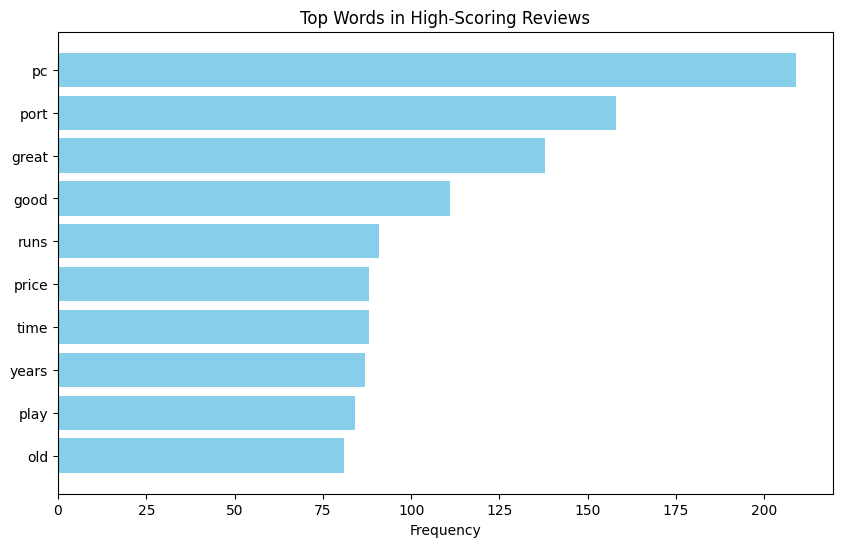

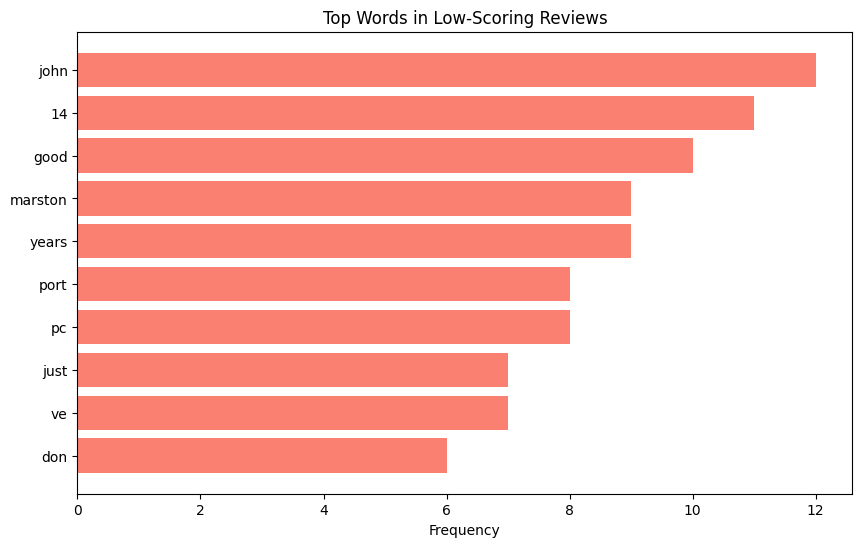

Reading with reviews-comp/reviews_1817070.csv


,review,positive,neutral,negative
0,Best Spider-Man game on PC for now,0.951427,0.046701,0.001872
1,love this!!,0.982137,0.014088,0.003775
2,The PC version is great. as someone who does not have a playstation this was my only option. Swinging around NYC is so fun. If you're unsure I'd say go ahead and get it.,0.980704,0.015666,0.003630
4,amazing game cant wait for spiderman 2 to come out on pc if you're wondering it launches on pc january 30th 2025,0.989281,0.009501,0.001218
5,The game can become repetitive if you aim to complete everything but the main story and side quests are engaging and enjoyable. Additionally the J. Jonah Jameson podcast is the perfect cherry on top :),0.950290,0.041743,0.007967
6,Really enjoying this game it ticks all the boxes of someone who loves open world 3rd person games like Assassin's Creed amd The Witcher 3.... I just gotta learn to be a better Spider Man and realize I'm not Arkham Batman.,0.941374,0.048429,0.010196
7,This is the game for you if all you want is to see Spider-Man swinging through the neighborhood and stopping crimes. But after playing the Arkham games I have to say it's just not that fun. The combat feels boring because all you have to do is mash one button and occasionally press dodge while the stealth seems dumbed down like they were trying to make it playable by young children. Also way too grindy. Like I said if you want a good super-hero fighting/stealth game go play Arkham.,0.029302,0.150549,0.820149
8,IT'S GOOD GAME,0.953330,0.040751,0.005919
9,very fun nice game,0.978702,0.017728,0.003570
12,Best Spider-Man game in years,0.963666,0.033873,0.002461


,review,positive,neutral,negative
28,MJNJ,0.137232,0.677721,0.185046
62,im the guy name petter pejasf,0.077230,0.865542,0.057229
92,spider-man anything else need to be said,0.047640,0.799587,0.152773
108,After activating all of the radio towers almost all of the collectables show up on the map. Even if you choose not to activate them the collectables are not in obvious spots (other than the photographs) like in the Arkham games. Imagine if every single shrine and deku child were revealed on the map in Breath of the Wild or they were all on the side of large skyscrapers on a random window.,0.145384,0.677988,0.176628
114,venoms in the sequel,0.120827,0.832740,0.046433
117,Man bite spider man become spider spider man fight angry asian man man spider win 9/10,0.177655,0.752719,0.069627
125,Makes you feel like you have the exaggerated swag of a Quirked Up White Boy Goated With The Sauce,0.181398,0.673797,0.144805
138,spooder-man,0.135747,0.664973,0.199279
156,you play as deh spooderguy and yuou doestnafraid of anythign,0.062244,0.788003,0.149752
181,ITS A CHILL GAME,0.155659,0.683747,0.160594


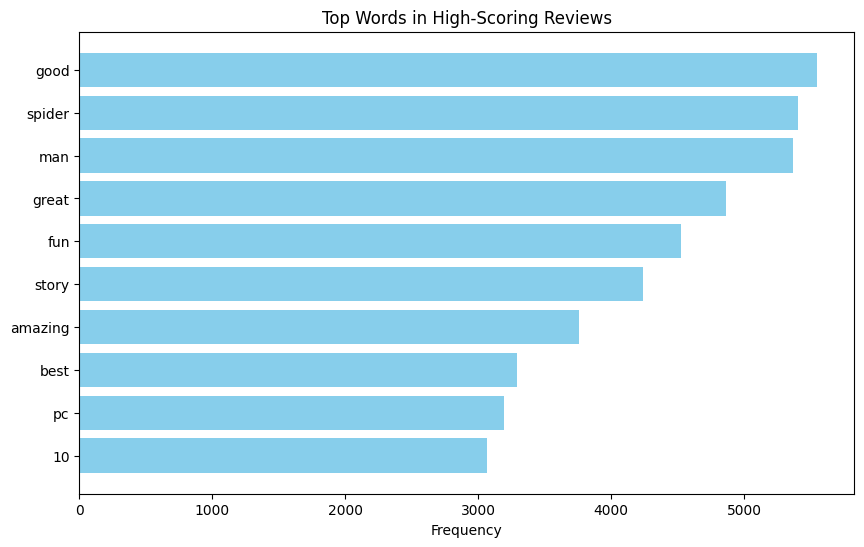

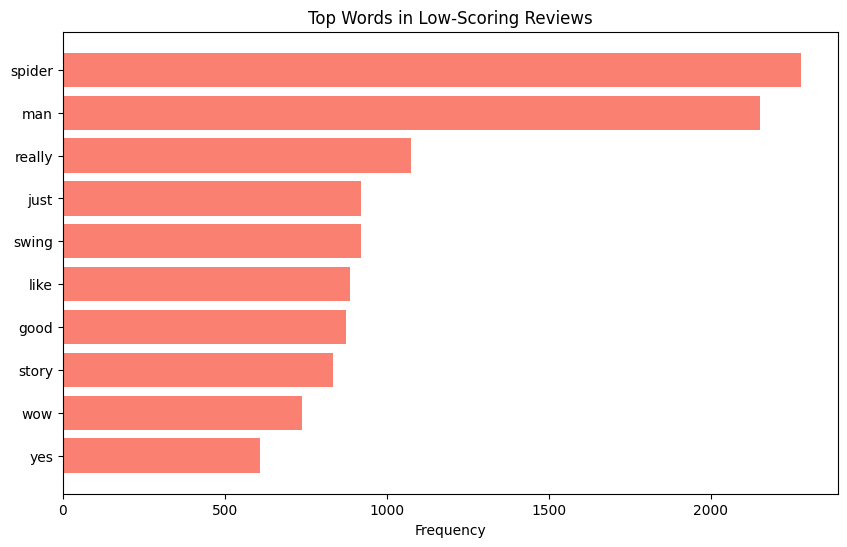

In [2]:
import pandas as pd
import ast
import re
import os
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

data_folder = "reviews-comp"

def getCSVs(folder) -> list[str]:
    return [f for f in os.listdir(folder) if f.endswith('.csv')]

# Sample function for loading, cleaning, and parsing the sentiment column as before
def clean_and_parse_sentiment(sentiment_str):
    cleaned_str = re.sub(r'np\.float32\(([\d\.]+)\)', r'\1', sentiment_str)
    return ast.literal_eval(cleaned_str)

def is_mostly_numeric(text):
    if not isinstance(text, str):
        return False
    return bool(re.fullmatch(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', text))

for file in getCSVs(data_folder):
    print(f"Reading with {data_folder}/{file}")
    data = pd.read_csv(f"{data_folder}/{file}", low_memory=False)
    if 'sentiment' not in data.columns:
        print(f"Skipping {file}: 'sentiment' column not found.")
        continue  # Skip this file and move to the next one
        
    # Assuming you have a DataFrame called 'data' with sentiment and review columns
    data = data[~data['review'].apply(is_mostly_numeric)]

    # Convert and parse the 'sentiments' column
    data['sentiments'] = data['sentiment'].apply(lambda x: clean_and_parse_sentiment(x) if isinstance(x, str) else x)

    # Extract individual sentiment scores and add them as separate columns
    data['positives'] = data['sentiments'].apply(lambda x: x.get('positive', 0))
    data['neutrals'] = data['sentiments'].apply(lambda x: x.get('neutral', 0))
    data['negatives'] = data['sentiments'].apply(lambda x: x.get('negative', 0))

    # Identify high and low sentiment scores
    high_threshold = 0.8  # Threshold for high scores, adjust as needed
    low_threshold = 0.2   # Threshold for low scores, adjust as needed

    # Filter for high scoring reviews (e.g., high positive or high negative)
    high_scoring_reviews = data[(data['positives'] >= high_threshold) | (data['negatives'] >= high_threshold)]

    # Filter for low scoring reviews (e.g., low positive and low negative, mostly neutral)
    low_scoring_reviews = data[(data['positives'] <= low_threshold) & (data['negatives'] <= low_threshold)]

    # Display the high and low scoring reviews
    high_scoring_styled = high_scoring_reviews[['review', 'positive', 'neutral', 'negative']].head(10).style \
        .set_caption("High Scoring Reviews") \
        .background_gradient(subset=['positive', 'neutral', 'negative'], cmap="Greens") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', 'black'), ('font-weight', 'bold')]},
            {'selector': 'table', 'props': [('border', '1px solid black')]}
        ]) \
        .set_properties(**{'text-align': 'left'})
    display(high_scoring_styled)
    
    low_scoring_styled = low_scoring_reviews[['review', 'positive', 'neutral', 'negative']].head(10).style \
        .set_caption("Low Scoring Reviews") \
        .background_gradient(subset=['positive', 'neutral', 'negative'], cmap="Reds") \
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', 'black'), ('font-weight', 'bold')]},
            {'selector': 'table', 'props': [('border', '1px solid black')]}
        ]) \
        .set_properties(**{'text-align': 'left'})
    display(low_scoring_styled)

    # Concatenate all high-scoring reviews and low-scoring reviews into single texts
    high_reviews_text = " ".join(high_scoring_reviews['review'].astype(str))
    low_reviews_text = " ".join(low_scoring_reviews['review'].astype(str))
    
    # Use CountVectorizer to find common words in high and low reviews
    custom_stop_words = list(CountVectorizer(stop_words='english').get_stop_words()) + ['game']

    # Use CountVectorizer to find common words in high and low reviews, excluding "game"
    vectorizer = CountVectorizer(stop_words=custom_stop_words, max_features=10)
    
    # Check if high and low reviews texts contain meaningful content before proceeding
    if high_reviews_text.strip():  # Proceed if high_reviews_text is not empty
        high_counts = vectorizer.fit_transform([high_reviews_text])
        high_common_words = vectorizer.get_feature_names_out()
        high_word_count = high_counts.toarray().flatten()     
        # Create DataFrame for high-scoring words and counts
        high_df = pd.DataFrame({'Word': high_common_words, 'Frequency': high_word_count})
        high_df = high_df.sort_values(by='Frequency', ascending=False)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(high_df['Word'], high_df['Frequency'], color='skyblue')
        plt.xlabel('Frequency')
        plt.title('Top Words in High-Scoring Reviews')
        plt.gca().invert_yaxis()  # Invert to show the most frequent word at the top
        plt.show()
    else:
        print("No significant words in high-scoring reviews after removing stop words.")

    if low_reviews_text.strip():  # Proceed if low_reviews_text is not empty
        low_counts = vectorizer.fit_transform([low_reviews_text])
        low_common_words = vectorizer.get_feature_names_out()
        low_word_count = low_counts.toarray().flatten()
        
        # Create DataFrame for low-scoring words and counts
        low_df = pd.DataFrame({'Word': low_common_words, 'Frequency': low_word_count})
        low_df = low_df.sort_values(by='Frequency', ascending=False)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(low_df['Word'], low_df['Frequency'], color='salmon')
        plt.xlabel('Frequency')
        plt.title('Top Words in Low-Scoring Reviews')
        plt.gca().invert_yaxis()  # Invert to show the most frequent word at the top
        plt.show()
    else:
        print("No significant words in low-scoring reviews after removing stop words.")
